In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import re
import os
import copy
import pickle
import seaborn as sns
import gzip
import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
#import pygraphviz
import datetime
from itertools import combinations
date = datetime.datetime.now().strftime("%Y-%m-%d")
#from colorspacious import cspace_converter
#for statistics
from scipy.stats import ttest_ind
import statistics
from scipy.stats import chisquare
from scipy.stats import binomtest#ztest

In [3]:
def extract_alignments(pacbio,ed,un,blasted,blastun,outfile='PacBio.maxi_mRNA.fasta'):
    keys=['query', 'subject', 'identity', 'alignment_length', 'mismatches', 'gap' , 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bit_score']#fields in blastn format 6
    blasted=[{k:v if k == 'query' or k == 'subject' else float(v) for k,v in zip(keys,l.strip('\n').split('\t'))} for l in open(blasted)]
    blastun=[{k:v if k == 'query' or k == 'subject' else float(v) for k,v in zip(keys,l.strip('\n').split('\t'))} for l in open(blastun)]
  #filter
    def filter(blast):
        new=[b for b in blast if b['identity']>=90 and b['sstart']<b['send']]
        new={f"{b['subject']}_{b['sstart']}_{b['send']}":b for b in new}
        trans={}
        for k,v in new.items():
            if v['subject'] in trans:
                trans[v['subject']].append(k)
            else:
                trans[v['subject']]=[k]
        return new, trans
    blasted2,edtrans=filter(blasted)
    blastun2,untrans=filter(blastun)
    reads=set(edtrans.keys()).union(set(untrans.keys()))
    records=[SeqRecord(v.seq,id=v.id,name=v.name,description=v.description) for k,v in pacbio.items() if k in reads]
    #SeqIO.write(records,outfile,'fasta')
    return (blasted2,edtrans,blastun2,untrans)
#mark it the mRNA is edited or unedited
def change_id(seqiodict,surfix):
    for k,v in seqiodict.items():
        v.id=f"{v.id}_{surfix}"
        v.name=f"{v.name}_{surfix}"
        v.description=f"{v.description}_{surfix}"
    return seqiodict
def change_blast(blast,surfix):
    for k in blast:
        blast[k]['query']=f"{blast[k]['query']}_{surfix}"
    return blast
#combine dict
def combine_blast_dict(blastedf,blastunf):
    comb={}
    def add_dict(blast,comb):
        for k,v in blast.items():
            if v['subject'] not in comb:
                comb[v['subject']]=[v]
            else:
                comb[v['subject']].append(v)
        return comb
    comb=add_dict(blastedf,comb)
    comb=add_dict(blastunf,comb)
    return(comb)

#show annotation of reads, not aligned
def plot_read_annotation(combined,pacbio,colors,mrnas):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 100), sharey=False)
    d,width=0,2
    for mrna in mrnas[::-1]:
        for k,read in combined.items():
            anno=[hit['query'].replace('_un','').replace('_ed','') for hit in read]
            if mrna in anno: #align to the edited mRNA
                edstarts=[hit['qstart'] for hit in read if 'ed' in hit['query'] and mrna in hit['query']]
                #print(edstarts)
                try:
                    ax.hlines(d,0,len(pacbio[k].seq))
                    for hit in read:
                        if 'ed' in hit['query']:
                            ax.add_patch(Rectangle((hit['sstart'], d), hit['send']-hit['sstart'], width,hatch='////',
                                              facecolor = colors.get(hit['query'].replace('_ed',''),'gray'),alpha=0.8)) #coding region
                        else:
                            #unedited hits
                            ax.add_patch(Rectangle((hit['sstart'], d), hit['send']-hit['sstart'], width,
                                              facecolor = colors.get(hit['query'].replace('_un',''),'gray'),alpha=0.8)) #coding region
                except:
                    print(k)
                d+=width
    plt.show()



In [4]:
#
ed='/home/jovyan/Tcongo_PacBio/Infiles/trans_corrected_edited_mRNA_0601.T.fa'
un='/home/jovyan/Tcongo_PacBio/Infiles/IL3000_transcriptom_unedited_mRNA.T.fa'
maxi='/home/jovyan/Tcongo_PacBio/Infiles/maxicircle_Tcongolense.fasta'
ed=SeqIO.to_dict(SeqIO.parse(ed,'fasta'))
un=SeqIO.to_dict(SeqIO.parse(un,'fasta'))
maxi=SeqIO.read(maxi,'fasta')
edmrna=change_id(ed,'ed')
unmrna=change_id(un,'un')
#
#actually these are bsf
blastun='/home/jovyan/Tcongo_PacBio/Infiles/blastn_IL3000_transcriptom_unedited_mRNA.T.fa_against_IL3000_prycyclic.pacbio.txt'
blasted='/home/jovyan/Tcongo_PacBio/Infiles/blastn_trans_corrected_edited_mRNA_0601.T.fa_against_IL3000_prycyclic.pacbio.txt'
#
epiblastun='/home/jovyan/Tcongo_PacBio/Infiles/blastn_IL3000_transcriptom_unedited_mRNA.T.fa_against_IL3000_epimastigote.pacbio.txt'
epiblasted='/home/jovyan/Tcongo_PacBio/Infiles/blastn_trans_corrected_edited_mRNA_0601.T.fa_against_IL3000_epimastigote.pacbio.txt'

#
hitreads='/home/jovyan/Tcongo_PacBio/Infiles/PacBio.maxi_mRNA.fasta'
epihits='/home/jovyan/Tcongo_PacBio/Infiles/PacBio.epi.maxi_mRNA.fasta'
colors={'CYB':'greenyellow','MURF2':'orange', 'CR3':'green', 'RPS12':'purple',  'ND7':'brown', 'ND8':'pink', 'ND8':'pink',
    'A6_v1':'red','A6_v2':'red', 'A6':'red','COX3':'cyan',  'CR4':'cornflowerblue', 'ND3':'magenta', 
        'ND9':'olive','COX2':'blue','CR4':'green'}
#load read files
pacbio=SeqIO.to_dict(SeqIO.parse(hitreads,'fasta'))
epipacbio=SeqIO.to_dict(SeqIO.parse(epihits,'fasta'))
#
copy_dict={k:int(v.description.split(';')[0].split('=')[1]) for k,v in pacbio.items()}
epi_copy={k:int(v.description.split(';')[0].split('=')[1]) for k,v in epipacbio.items()}
#

#mrnas=['A6','COX2','COX3','CR3','CYB','MURF2','ND3','ND7','ND8','ND9','RPS12','ND5']
mrnas=['12srRNA','9srRNA','ND8','ND9','uS3m','ND7','COX3','CYB','A6','MURF1','CR3','ND1',
       'COX2','MURF2','COX1','CR4','ND4','ND3','RPS12','ND5']

In [5]:
#bloodstream form
blastedf,edtrans,blastunf,untrans=extract_alignments(pacbio,ed,un,blasted,blastun)
blastedf=change_blast(blastedf,'ed')
blastunf=change_blast(blastunf,'un')
combined=combine_blast_dict(blastedf,blastunf)

In [6]:
#epimastigote
blasted_epi,edtrans_epi,blastun_epi,untrans_epi=extract_alignments(epipacbio,ed,un,epiblasted,epiblastun)
blasted_epi=change_blast(blasted_epi,'ed')
blastunf_epi=change_blast(blastun_epi,'un')
combined_epi=combine_blast_dict(blasted_epi,blastun_epi)

In [7]:
def extract_alignments2(pacbio,maxi,maxi_blast,outfile='PacBio.ts_maxi_hits.fasta'):
    keys=['query', 'subject', 'identity', 'alignment_length', 'mismatches', 'gap' , 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bit_score']#fields in blastn format 6
    blast_ts=[{k:v if k == 'query' or k == 'subject' else float(v) for k,v in zip(keys,l.strip('\n').split('\t'))} 
              for l in open(maxi_blast)]
  #filter
    def filter(blast):
        new=[b for b in blast if b['identity']>=90 and b['sstart']<b['send']]
        new={f"{b['subject']}_{b['sstart']}_{b['send']}":b for b in new}
        trans={}
        for k,v in new.items():
            if v['subject'] in trans:
                trans[v['subject']].append(k)
            else:
                trans[v['subject']]=[k]
        return new, trans
    blasted2,trans2=filter(blast_ts)
    records=[SeqRecord(v.seq,id=v.id,name=v.name,description=v.description) for k,v in pacbio.items() if k in trans2.keys()]
    #SeqIO.write(records,outfile,'fasta')
    return (blasted2,trans2)
blastnmaxi_bsf='/home/jovyan/Tcongo_PacBio/Infiles/blastn_maxicircle_Tcongolense.ts_against_IL3000_bsf.pacbio.ts.txt'
blastdict_bsf,maxitrans=extract_alignments2(pacbio,maxi,blastnmaxi_bsf)
len(maxitrans.keys())
#len(combined)


292

In [8]:
def read_stats(reads,copy_dict):
    lengths=[]
    print(f"{len(reads)} reads detected")
    for k,v in reads.items():
        lengths+=[len(v.seq)]*copy_dict[k]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey=False)
    ax.hist(lengths,bins=range(round(min(lengths)),max(lengths),50))
    ax.set_xlabel(f"PacBio read length")
    ax.set_ylabel(f"read count")
    plt.show()
def edited_unedited(edtrans,untrans,copy_dict):
    both=set(edtrans.keys()).intersection(set(untrans.keys()))
    edun=sum([copy_dict[k] for k in both])
    ed=sum([copy_dict[k] for k,v in edtrans.items() if k not in both])
    un=sum([copy_dict[k] for k,v in untrans.items() if k not in both])
    unique=set(edtrans.keys()).union(set(untrans.keys()))
    print(f"#edited/unedited:{edun},only edited:{ed}, only unedited: {un} total {edun+ed+un} total unique {len(unique)} ")
    return [edun,ed,un]
def compare_ratio(count1,count2):
    ratio1=[i/sum(count1) for i in count1]
    for i,j in zip(count2,ratio1):
        z=binomtest(i,sum(count2),j)
        if z.pvalue<0.05:
            print(i,i/sum(count2),j)

In [9]:
count1=edited_unedited(edtrans,untrans,copy_dict) #bsf
count2=edited_unedited(edtrans_epi,untrans_epi,epi_copy)
compare_ratio(count1,count2)

#edited/unedited:13624,only edited:3221, only unedited: 5953 total 22798 total unique 578 
#edited/unedited:4874,only edited:157, only unedited: 1701 total 6732 total unique 263 
4874 0.7240047534165182 0.5975962803754715
157 0.023321449792038026 0.1412843231862444


265 reads detected


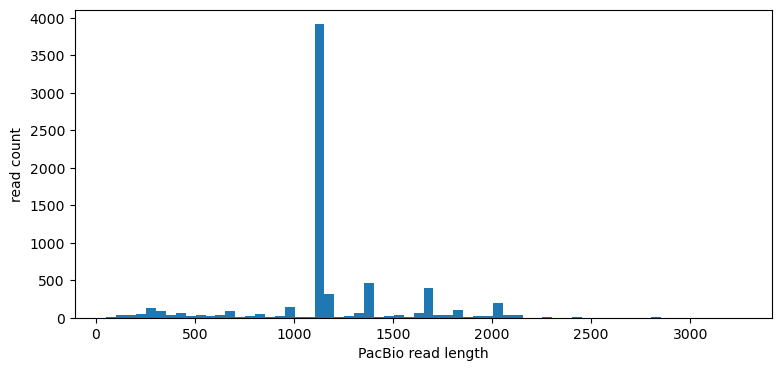

578 reads detected


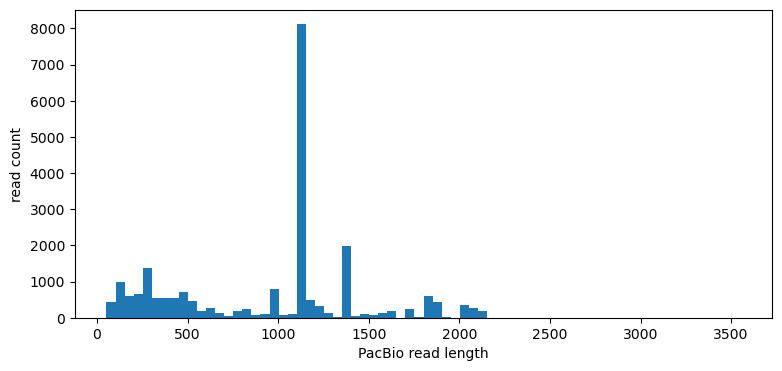

In [10]:
#use actual number of reads
read_stats(epipacbio,epi_copy)
read_stats(pacbio,copy_dict)

In [11]:
#extract edited regions from reads
def extract_edited(pacbio,combined,outdir):
    for mrna in mrnas:
        records=[]
        for k,read in combined.items():
            for hit in read:
                if 'ed' in hit['query'] and hit['query'].replace('_ed','') ==mrna:
                    try:
                        records.append(SeqRecord(pacbio[k].seq[int(hit['sstart']):int(hit['send'])],id=f"{k}_{hit['sstart']}-{hit['send']}",
                                        name=pacbio[k].name,description=pacbio[k].description))
                    except:
                        print(k)
        SeqIO.write(records,f"{outdir}/{mrna}.edited.fasta",'fasta')
##
def extract_unedited(pacbio,combined,outdir):
    unreads={}
    for mrna in mrnas:
        records=[]
        for k,read in combined.items():
            for hit in read:
                if 'un' in hit['query'] and hit['query'].replace('_un','') ==mrna:
                    try:
                        records.append(SeqRecord(pacbio[k].seq[int(hit['sstart']):int(hit['send'])],id=f"{k}_{hit['sstart']}-{hit['send']}",
                                        name=pacbio[k].name,description=pacbio[k].description))
                    except:
                        print(k)
        SeqIO.write(records,f"{outdir}/{mrna}.unedited.fasta",'fasta')
        unreads[mrna]=records
    return(unreads)

In [12]:
def split_reads(pacbio,combined):
    records1,records2,records3=[],[],[]
    for k,hits in combined.items():
        edun=set([hit['query'].split('_')[-1] for hit in hits])
        if edun=={'ed','un'}:
            re
            print(edun)
        
#split_reads(pacbio,combined)

In [13]:
outdir='/home/jovyan/Tcongo_PacBio/Workfiles'
extract_edited(pacbio,combined,outdir)
bsf_unreads=extract_unedited(pacbio,combined,outdir)
#
outdir='/home/jovyan/Tcongo_PacBio/Workfiles/Epimastigote'
extract_edited(epipacbio,combined_epi,outdir)
epf_unreads=extract_unedited(epipacbio,combined_epi,outdir)

In [14]:
#Polycistronic
def polycistronic(combined,copy_dict):
    poly={1:{},2:{},3:{}}
    counts={}
    for k,v in combined.items():
        #print(k)
        genes=set([hit['query'].split('_')[0] for hit in v])
        poly[len(genes)][k]='_'.join(sorted(list(genes)))
    total=sum([sum(copy_dict[k] for k in poly[n].keys()) for n in poly])
    for n in poly:
        count=sum(copy_dict[k] for k in poly[n].keys())
        counts[n]=count
        print(f"{n} gene(s): {count} {round(count/total*100,1)}")
    print(total)
    for genen in [2,3]:
        print(genen)
        genes=set(list(poly[genen].values()))
        for i in genes:
            tmp=sum([copy_dict[k] for k,v in poly[genen].items() if v==i])
            print(i,tmp,round(tmp/counts[genen]*100,1))
    
        
polycistronic(combined,copy_dict)
polycistronic(combined_epi,epi_copy)

1 gene(s): 15345 67.3
2 gene(s): 7443 32.6
3 gene(s): 10 0.0
22798
2
COX3_ND7 54 0.7
COX2_MURF2 25 0.3
ND5_RPS12 1189 16.0
ND1_ND7 2 0.0
COX3_CYB 6027 81.0
COX3_ND8 4 0.1
9srRNA_RPS12 2 0.0
COX1_CR4 140 1.9
3
COX3_CYB_ND3 2 20.0
A6_COX3_CYB 2 20.0
ND4_ND5_RPS12 2 20.0
COX3_CYB_ND7 2 20.0
COX1_COX3_CYB 2 20.0
1 gene(s): 1941 28.8
2 gene(s): 4773 70.9
3 gene(s): 18 0.3
6732
2
COX3_ND7 31 0.6
CR3_MURF2 2 0.0
COX2_MURF2 83 1.7
CR4_CYB 2 0.0
ND5_RPS12 255 5.3
COX3_CYB 3991 83.6
COX1_CR4 407 8.5
ND9_uS3m 2 0.0
3
CR3_ND5_RPS12 2 11.1
A6_COX3_CYB 6 33.3
12srRNA_COX1_CR4 2 11.1
12srRNA_COX3_ND7 2 11.1
COX1_COX2_MURF2 2 11.1
COX3_CYB_ND5 2 11.1
COX1_COX3_CYB 2 11.1


In [15]:
#count number of reads with junctions

def junctions(combined,copy_dict):
    gene_junction={}
    count,total,ed,un=0,0,0,0
    for k,v in combined.items():
        test=0
        genes=[g for g in set([hit['query'].replace('_ed','').replace('_un','').replace('_v1','') for hit in v]) if g not in ['CYB','MURF2']]
        hits=[hit['query'].replace('_v1','') for hit in v]
        if len(set(genes).difference(['CYB','MURF2','12srRNA','9srRNA','COX1','MURF1','MURF5','ND1','ND4','ND5']))!=0:
            total+=copy_dict[k]
            for g in genes:
                if f"{g}_ed" in hits and f'{g}_un' in hits:
                    test+=1
                    if g in gene_junction:
                        gene_junction[g]+=copy_dict[k]
                    else:
                        gene_junction[g]=copy_dict[k]
            if test==0:
                for g in genes:
                    if f"{g}_ed" in hits:
                        ed+=copy_dict[k]
                        break
                    else:
                        un+=copy_dict[k]
                        break
            if test>0:
                count+=copy_dict[k]
            if test>1:
                print(k,hits)
    print(f"total reads with pan-edited mRNA: {total}, reads with junction: {count}, unedited only: {un}, edited only: {ed}, \nsum of individual mRNA {sum(gene_junction.values())}, sum of edited, partial, and unedited {sum([count,ed,un])}")
    print(gene_junction)
                

#BSF
junctions(combined,copy_dict)
#EMF
junctions(combined_epi,epi_copy)

total reads with pan-edited mRNA: 14942, reads with junction: 10020, unedited only: 1134, edited only: 3788, 
sum of individual mRNA 10020, sum of edited, partial, and unedited 14942
{'A6': 250, 'COX2': 25, 'COX3': 6344, 'CR3': 289, 'CR4': 6, 'ND3': 14, 'ND7': 307, 'ND8': 1441, 'ND9': 224, 'RPS12': 1120}
transcript/63541 ['A6_ed', 'COX3_ed', 'CYB_ed', 'A6_un', 'COX3_un', 'CYB_un']
transcript/76097 ['A6_ed', 'COX3_ed', 'CYB_ed', 'A6_un', 'COX3_un', 'CYB_un']
total reads with pan-edited mRNA: 5409, reads with junction: 2439, unedited only: 2809, edited only: 161, 
sum of individual mRNA 2443, sum of edited, partial, and unedited 5409
{'A6': 43, 'COX3': 2127, 'COX2': 85, 'CR3': 25, 'ND7': 32, 'ND8': 44, 'ND9': 6, 'RPS12': 81}


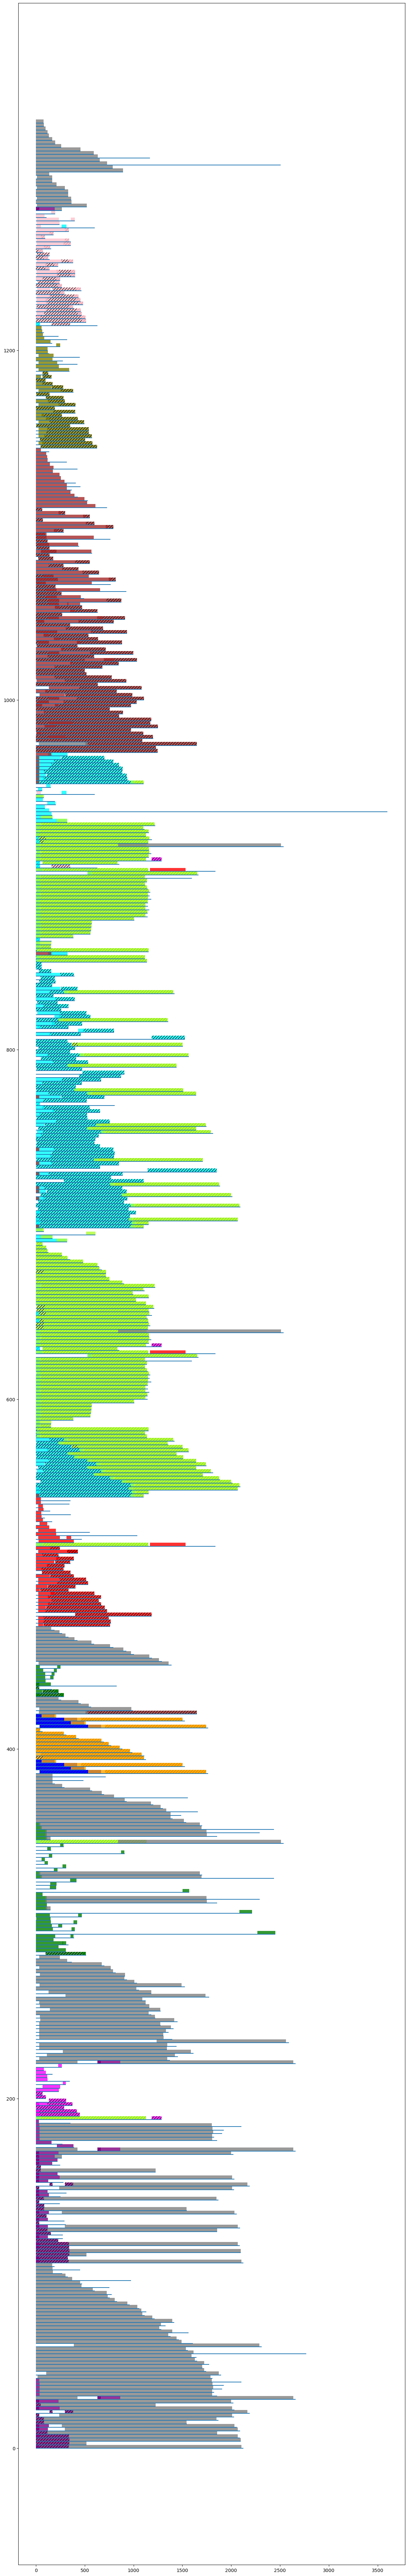

In [16]:
#show annotation of reads, not aligned
plot_read_annotation(combined,pacbio,colors,mrnas)

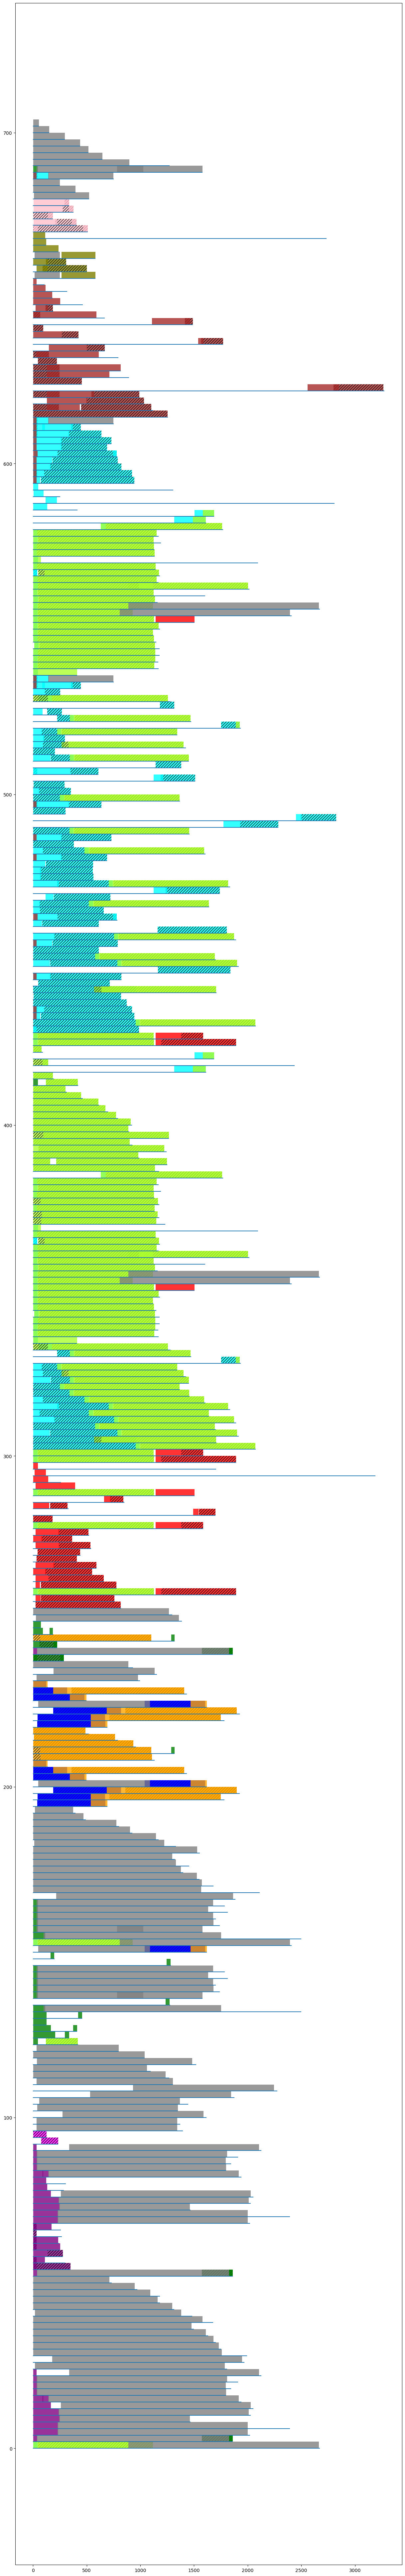

In [17]:
#show annotation of reads, not aligned
plot_read_annotation(combined_epi,epipacbio,colors,mrnas)

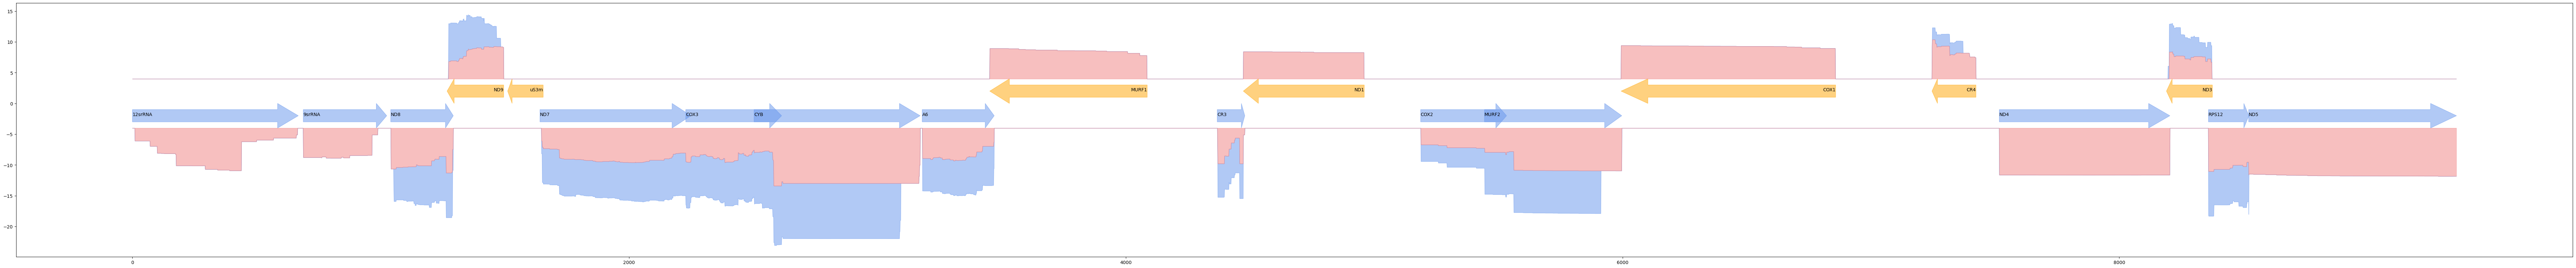

In [18]:
def locate_mRNA_on_maxi(maxi,unmrna):
    mrna_on_maxi={}
    for k,mrna in unmrna.items():
        s=maxi.seq.find(mrna.seq.upper().replace('U','T'))
        orient='coding'
        if s==-1:
            s=maxi.seq.find(mrna.seq.upper().replace('U','T').reverse_complement().upper())
            orient='template'
        e=s+len(mrna.seq)
        tss=len(maxi.seq[:s].replace('T',''))
        tse=len(maxi.seq[:e].replace('T',''))
        mrna_on_maxi[k]={'start':s,'ts_start':tss,'end':e,'ts_end':tse,'orient':orient}
    mrna_on_maxi={k: v for k, v in sorted(mrna_on_maxi.items(), key=lambda item: item[1]['start'])}
    return(mrna_on_maxi)
def draw_maxi_ts(ax,mrna_on_maxi,maxi,figw=50,figh=5,w=2):
    for mrna,v in mrna_on_maxi.items():
        dx=v['ts_end']-v['ts_start']
        if v['orient']=='coding':
            ax.arrow(v['ts_start'], -w, dx*7/8, 0, color='cornflowerblue',width=w,head_width=w*2,head_length=dx/8,alpha=0.5)
            ax.text(v['ts_start'], -w,mrna)
        else:
            #draw the T-stripped sequence on the coding strand
            #ax.arrow(v['ts_end'], 0, -dx*7/8, 0, color='orange',width=w,head_width=w*2,head_length=dx/8,alpha=0.5)
            #draw the actual T-stripped sequence that's used in the mRNA
            dx=len(maxi[v['start']:v['end']].seq.replace('A',''))
            ax.arrow(v['ts_start']+dx,w, -dx*7/8, 0, color='orange',width=w,head_width=w*2,head_length=dx/8,alpha=0.5)
            ax.text(v['ts_start']+dx, w,mrna,ha='right')
    #plt.show()
def draw_maxi(ax,mrna_on_maxi,figw=50,figh=5,w=2):
    for mrna,v in mrna_on_maxi.items():
        dx=v['end']-v['start']
        if v['orient']=='coding':
            ax.arrow(v['start'], 0, dx*7/8, 0, color='cornflowerblue',width=w,head_width=w*2,head_length=dx/8)
        else:
            ax.arrow(v['end'], 0, -dx*7/8, 0, color='orange',width=w,head_width=w*2,head_length=dx/8)
    #plt.show()
def tstripped_mRNA_coverage(maxi,combined,edmrna,unmrna,copy_dict): #choose blasted or blastun as input
    coverage={k:[] for k in combined}
    for k,transcripts in combined.items():
        coverage[k]=[]
        for v in transcripts:
            query=v['query'].split('_')[0]
            orient=mrna_on_maxi[query]['orient']
            if 'ed' in v['query'] and query in ['ND8','ND9','ND7','COX2','COX3','CYB','A6','CR3','MURF2','CR4','ND3','RPS12','ND5']:
                ed='ed'
                mrna=edmrna[query].seq.replace('U','T').upper()
            else: #['12srRNA','9srRNA','uS3m','MURF1','CR3','COX2','COX1','ND4','ND5']
                ed='un'
                mrna=unmrna[query].seq.replace('U','T').upper()
            if orient=='coding':
                s=len(mrna[:int(v['qstart'])].upper().replace('U','').replace('T',''))
                e=len(mrna[:int(v['qend'])].upper().replace('U','').replace('T',''))
            elif orient=='template':
                end=len(mrna.upper().replace('U','').replace('T',''))
                stmp=len(mrna[:int(v['qstart'])].upper().replace('U','').replace('T',''))
                etmp=len(mrna[:int(v['qend'])].upper().replace('U','').replace('T',''))
                s=end-etmp
                e=end-stmp
            coverage[k].append({'mRNA':query,'edited':ed,'start':s,'end':e})
    return(coverage)
def plot_ts_transcripts(ts_coverage,mrna_on_maxi,maxi,figw=100,figh=5,w=2,floor=-30,upper_bound=30):
    ts_coverage={k: v for k, v in sorted(ts_coverage.items(), key=lambda x: min([tr['start']+mrna_on_maxi[tr['mRNA']]['ts_start'] for tr in x[1]]))}
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figw,figh))
    draw_maxi_ts(ax,mrna_on_maxi,maxi,figw=figw,figh=figh,w=w)
    d,ceiling,width,positive_floor,c,mrna_pre=-5,-5,w/2,5,5,''
    hatch={'ed':'////','un':''}
    for k,transcripts in ts_coverage.items():
        orient=[mrna_on_maxi[tr['mRNA']]['orient'] for tr in transcripts]
        mrna_left={tr['start']+mrna_on_maxi[tr['mRNA']]['ts_start']:tr['mRNA'] for tr in transcripts}
        left_most=mrna_left[min(mrna_left.keys())] #find the left most mRNA in a transcript
        #start a new column if the left most mRNA has changed
       # if left_most!=mrna_pre:
       #     mrna_pre=left_most
       #     if 'coding' in orient:
       #         d=ceiling
       #     else:
       #         c=positive_floor
        #draw above if template, else draw below
        if 'coding' in orient:
            for tr in transcripts:
                adj=mrna_on_maxi[tr['mRNA']]['ts_start']
                ax.add_patch(Rectangle((tr['start']+adj, d), tr['end']-tr['start'], width,facecolor = colors.get(tr['mRNA'],'gray'),alpha=0.8,hatch=hatch[tr['edited']]))
            d-=width
        else:
            for tr in transcripts:
                adj=mrna_on_maxi[tr['mRNA']]['ts_start']
                ax.add_patch(Rectangle((tr['start']+adj, c), tr['end']-tr['start'], width,facecolor = colors.get(tr['mRNA'],'gray'),alpha=0.8,hatch=hatch[tr['edited']]))
            c+=width
    ax.get_yaxis().set_visible(False)
    plt.show()
#draw the depth only
def get_ts_transcript_depth(ts_coverage,mrna_on_maxi,maxi,copy_dict,ts_end=9358):
    coding_ed,coding_un,template_ed,template_un=[1]*ts_end,[1]*ts_end,[1]*ts_end,[1]*ts_end
    ts_coverage={k: v for k, v in sorted(ts_coverage.items(), key=lambda x: min([tr['start']+mrna_on_maxi[tr['mRNA']]['ts_start'] for tr in x[1]]))}
    for k,transcripts in ts_coverage.items():
        cp=copy_dict[k]
        for tr in transcripts:
            adj=mrna_on_maxi[tr['mRNA']]['ts_start']
            if mrna_on_maxi[tr['mRNA']]['orient']=='coding'and tr['edited']=='ed':
                for i in range(tr['start']+adj,tr['end']+adj):
                    coding_ed[i]+=cp
            elif mrna_on_maxi[tr['mRNA']]['orient']=='coding'and tr['edited']=='un':
                for i in range(tr['start']+adj,tr['end']+adj):
                    coding_un[i]+=cp
            elif mrna_on_maxi[tr['mRNA']]['orient']=='template'and tr['edited']=='ed':
                for i in range(tr['start']+adj,tr['end']+adj):
                    template_ed[i]+=cp
            elif mrna_on_maxi[tr['mRNA']]['orient']=='template'and tr['edited']=='un':
                for i in range(tr['start']+adj,tr['end']+adj):
                    template_un[i]+=cp
    return([np.log(coding_ed)*(-1),np.log(coding_un)*(-1),np.log(template_ed),np.log(template_un)])
def plot_ts_depth(depths,ts_coverage,mrna_on_maxi,maxi,figw=100,figh=5,vshift=2):  
    ts_coverage={k: v for k, v in sorted(ts_coverage.items(), key=lambda x: min([tr['start']+mrna_on_maxi[tr['mRNA']]['ts_start'] for tr in x[1]]))}
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figw,figh))
    draw_maxi_ts(ax,mrna_on_maxi,maxi,figw=figw,figh=figh,w=vshift)
    x=range(len(depths[0]))
    def fast():
        #fast version
        #ax.plot(x,depths[0]+depths[1]-vshift*2, color='cornflowerblue')
        #ax.plot(x,depths[1]-vshift*2,color='lightcoral')
        #ax.plot(x,depths[2]+depths[3]+vshift*2, color='cornflowerblue')
        #ax.plot(x,depths[3]+vshift*2,color='lightcoral')
        ax.fill_between(x, depths[0]+depths[1]-vshift*2, depths[1]-vshift*2, color='cornflowerblue',alpha=0.5)
        ax.fill_between(x,depths[1]-vshift*2,-vshift*2,color='lightcoral',alpha=0.5)
        ax.fill_between(x, depths[2]+depths[3]+vshift*2, depths[3]+vshift*2, color='cornflowerblue',alpha=0.5)
        ax.fill_between(x,depths[3]+vshift*2,vshift*2,color='lightcoral',alpha=0.5)
    fast()
    #ax.get_yaxis().set_visible(False)
    plt.show()

#execution and common variable
mrna_on_maxi=locate_mRNA_on_maxi(maxi,unmrna)
ts_coverage=tstripped_mRNA_coverage(maxi,combined,edmrna,unmrna,copy_dict)
depths=get_ts_transcript_depth(ts_coverage,mrna_on_maxi,maxi,copy_dict)
plot_ts_depth(depths,ts_coverage,mrna_on_maxi,maxi,figw=100,figh=10,vshift=2)

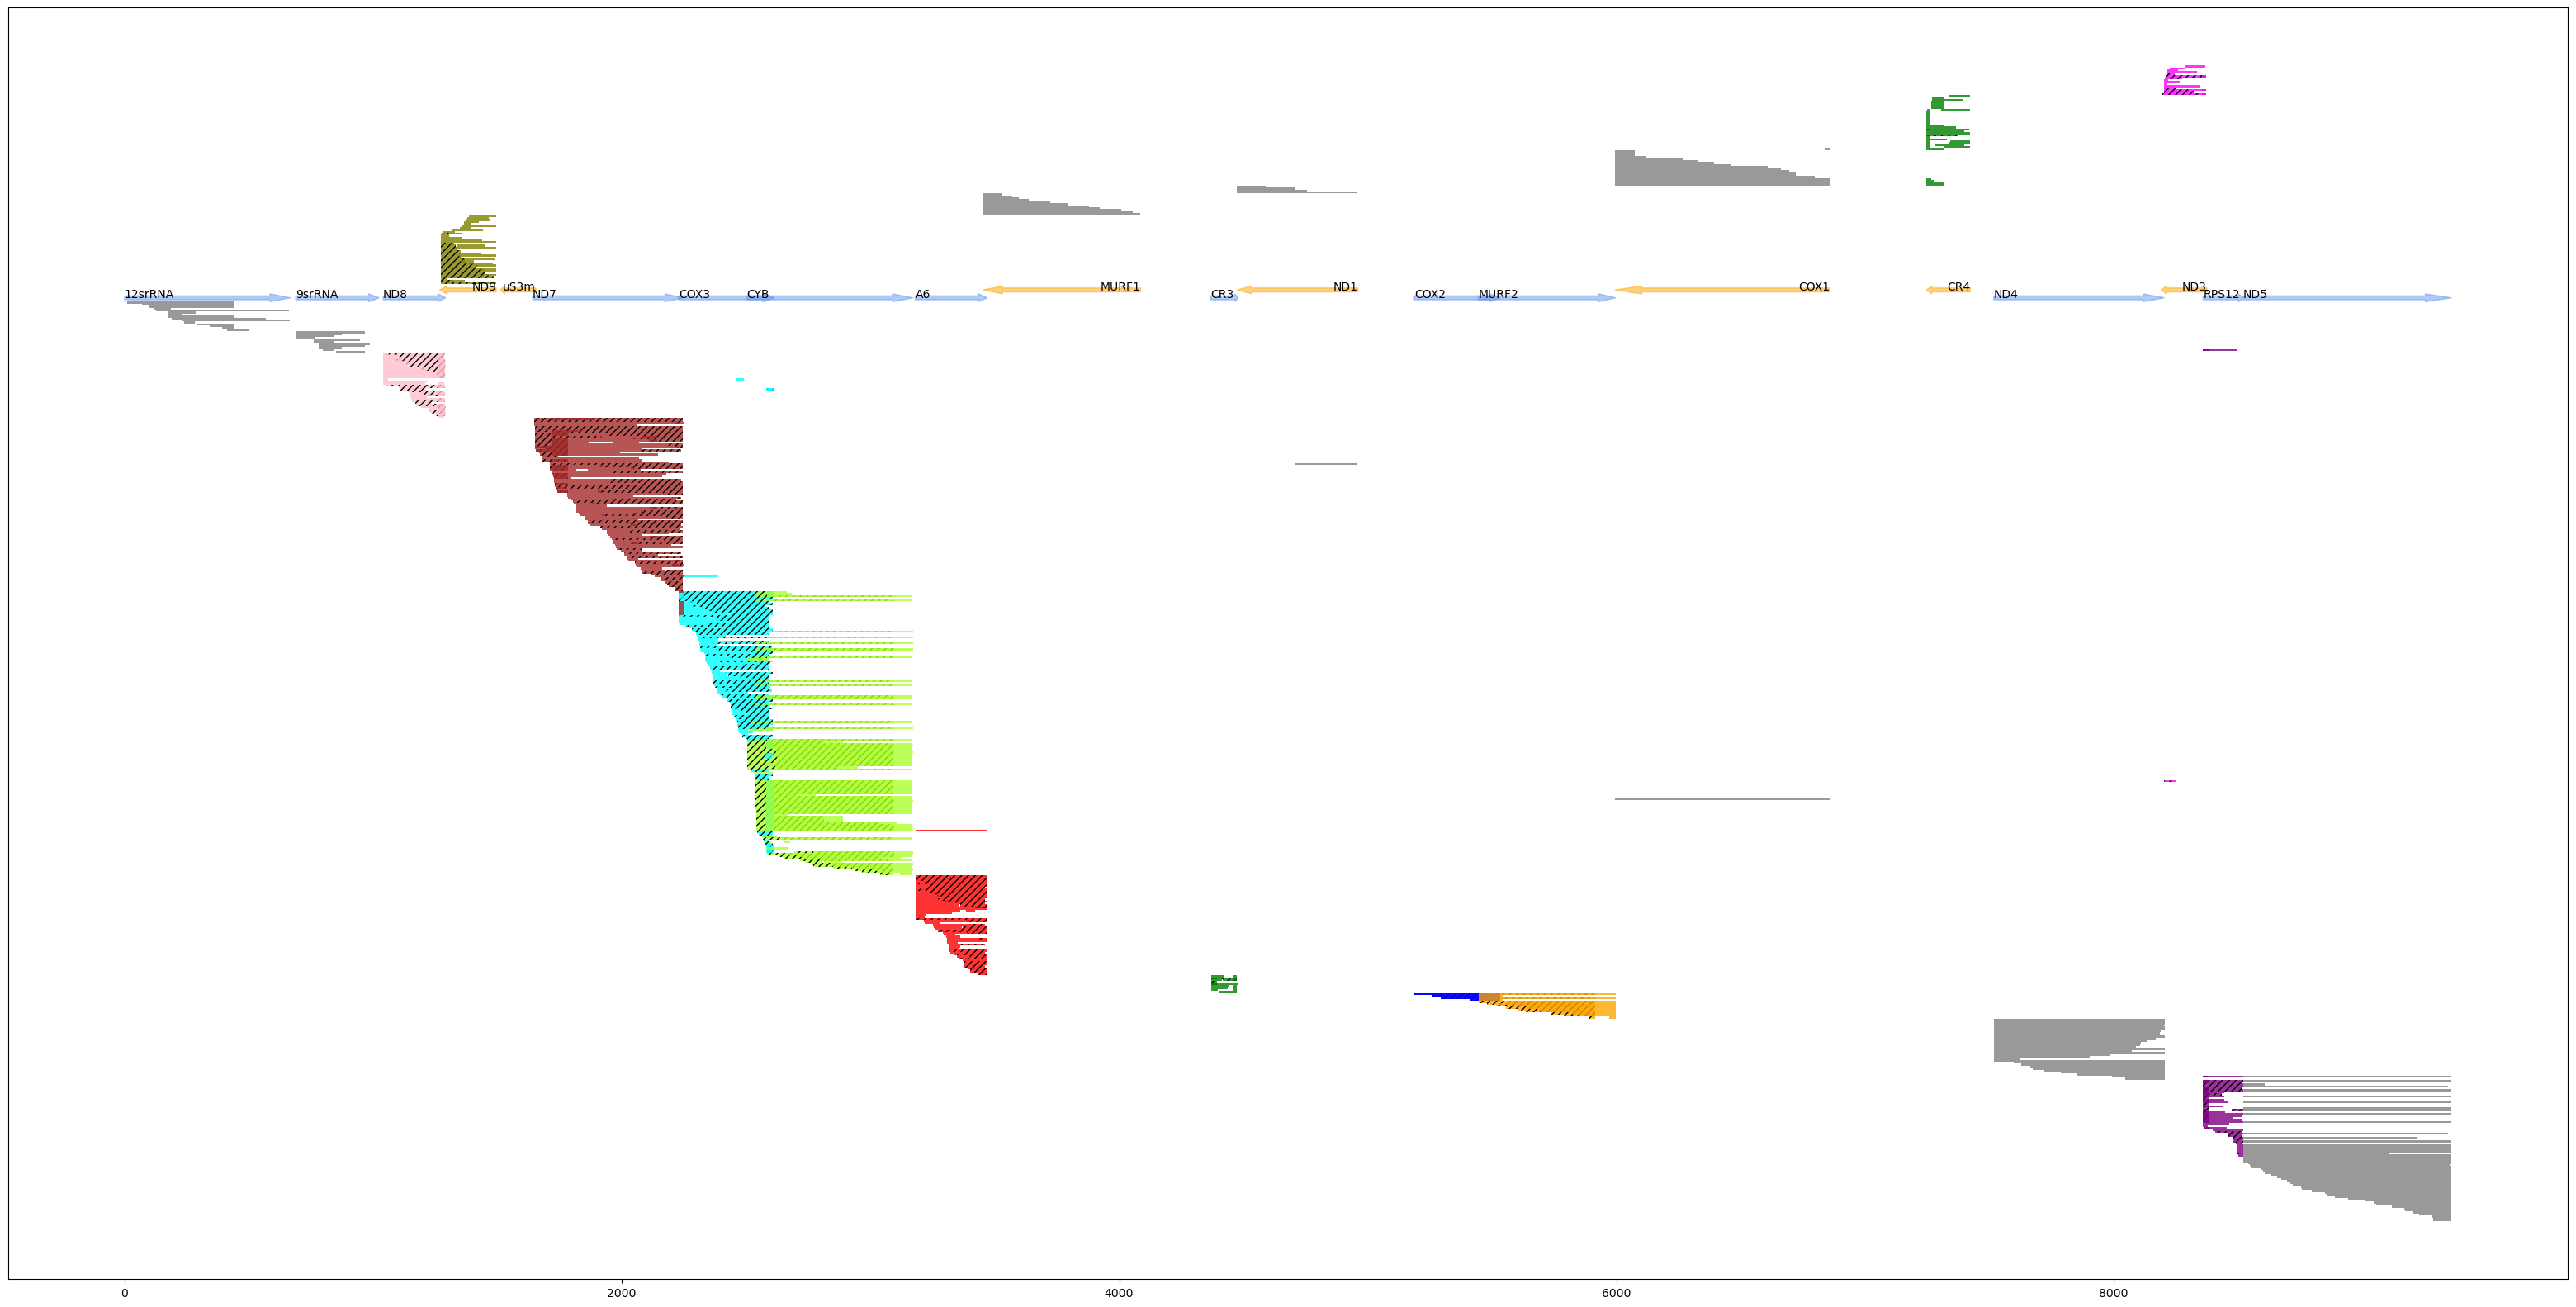

In [19]:
#BSF
ts_coverage=tstripped_mRNA_coverage(maxi,combined,edmrna,unmrna,copy_dict)
plot_ts_transcripts(ts_coverage,mrna_on_maxi,maxi,figw=40,figh=20,w=2,floor=-80,upper_bound=30)

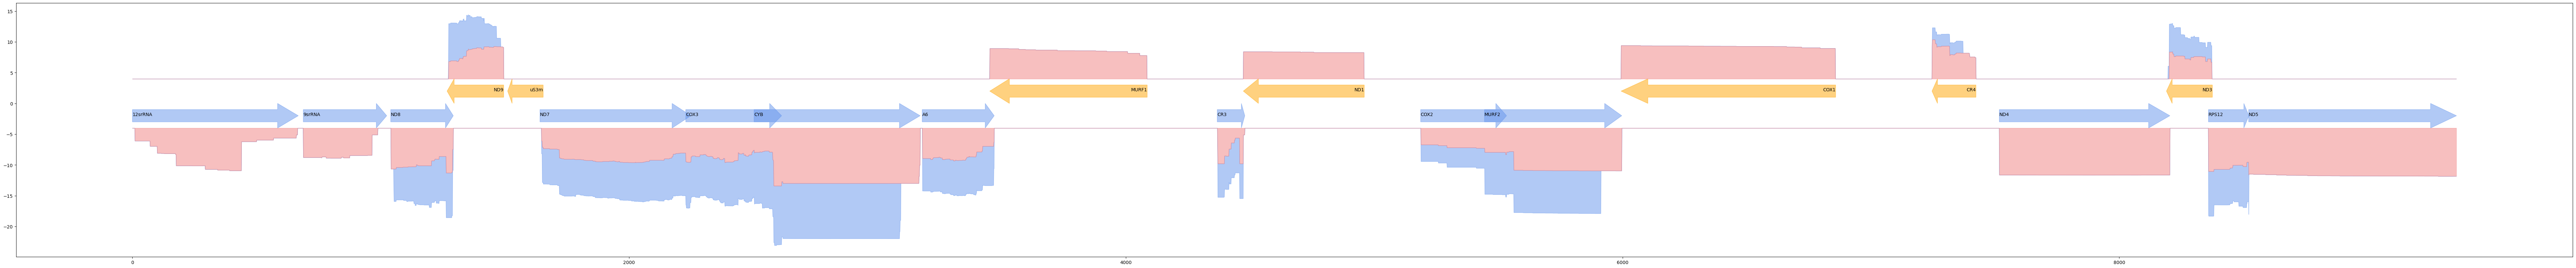

In [20]:
depths=get_ts_transcript_depth(ts_coverage,mrna_on_maxi,maxi,copy_dict)
plot_ts_depth(depths,ts_coverage,mrna_on_maxi,maxi,figw=100,figh=10,vshift=2)

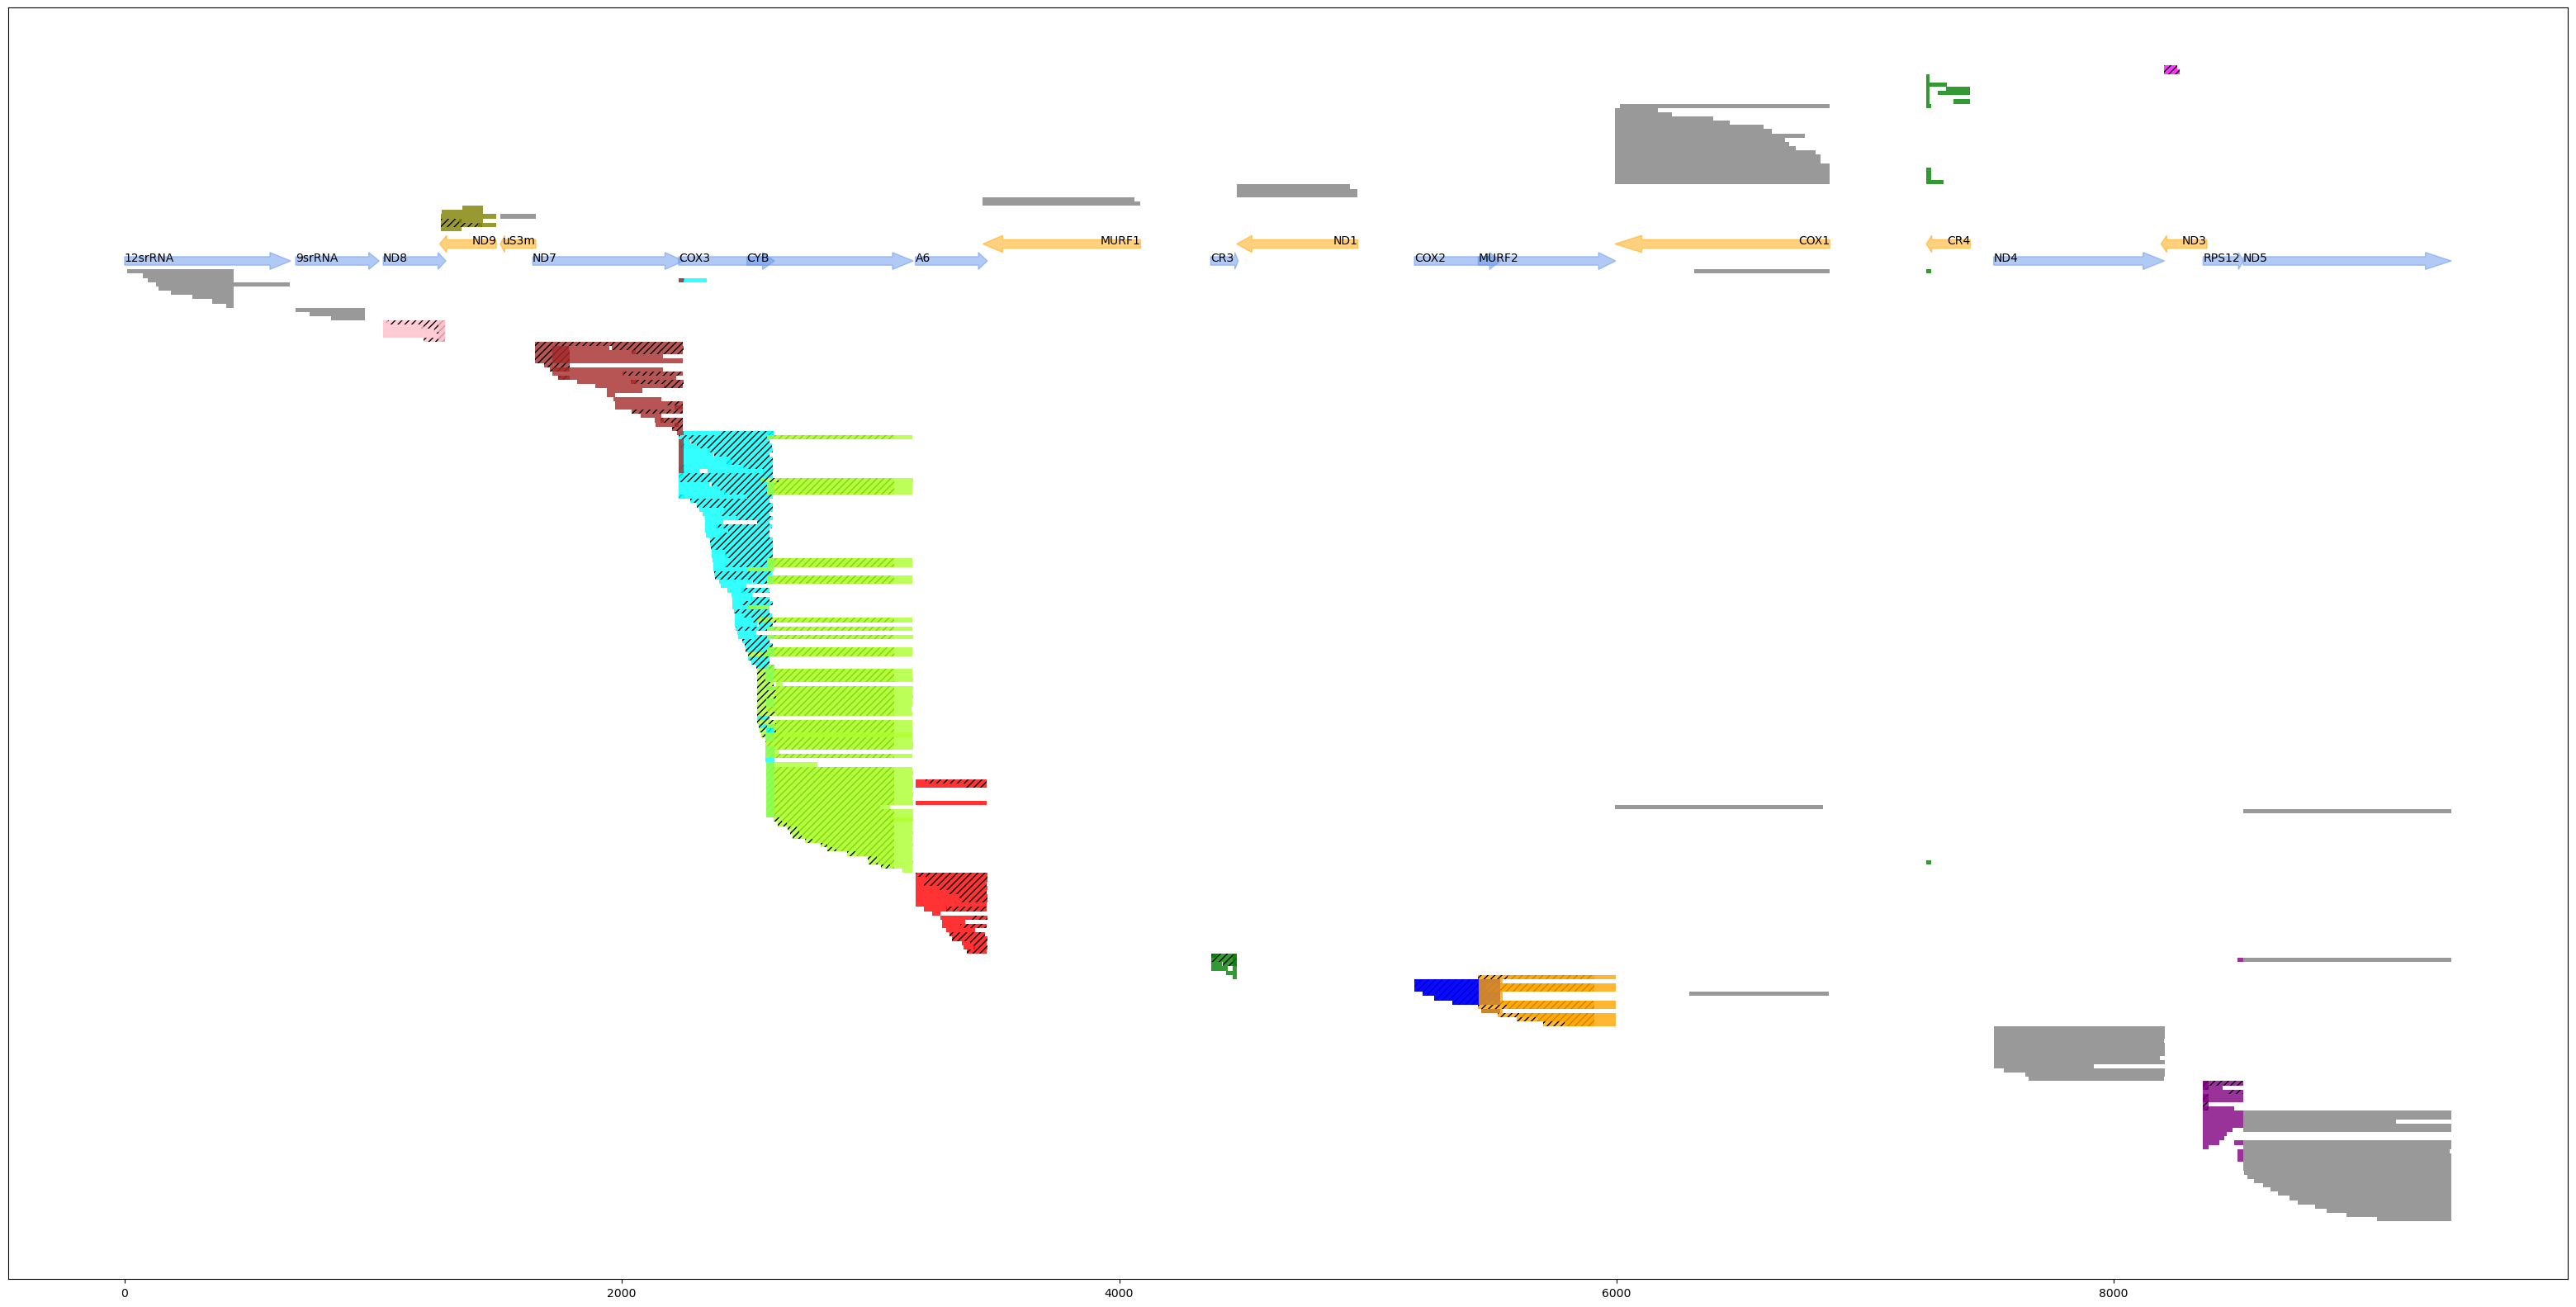

In [21]:
#epimastigotes
epi_ts_coverage=tstripped_mRNA_coverage(maxi,combined_epi,edmrna,unmrna,epi_copy)
plot_ts_transcripts(epi_ts_coverage,mrna_on_maxi,maxi,figw=40,figh=20,w=2,floor=-80,upper_bound=30)

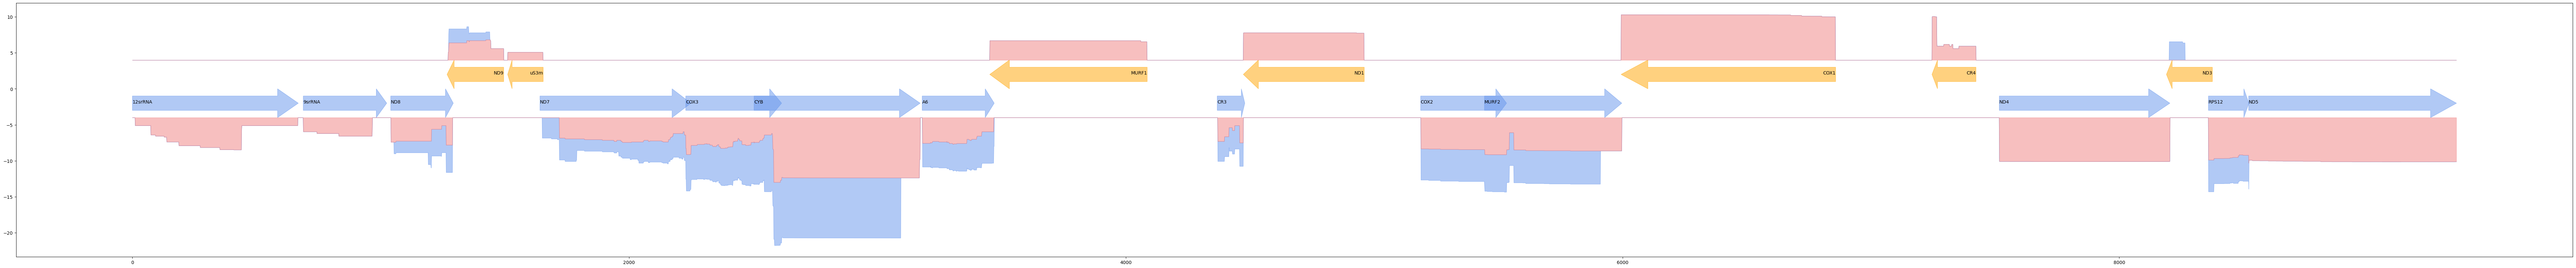

In [22]:
epi_depths=get_ts_transcript_depth(epi_ts_coverage,mrna_on_maxi,maxi,epi_copy)
plot_ts_depth(epi_depths,epi_ts_coverage,mrna_on_maxi,maxi,figw=100,figh=10,vshift=2)

In [23]:
def mRNA_coverage(blastedf,edmrna,unmrna,copy_dict,edited=True,figheight=50): #choose blasted or blastun as input
    if edited:
        lens,alignto={k.split('_')[0]:len(v.seq) for k,v in edmrna.items()},1
    else:
        lens,alignto={k.split('_')[0]:len(v.seq) for k,v in unmrna.items()},2
    coverage={k:[] for k in lens}
    for k,v in blastedf.items():
        query=v['query'].split('_')[0]
        coverage[query].append((v['subject'],v['qstart'],v['qend']))
    for mrna,v in coverage.items():
        coverage[mrna].sort(key=lambda element: element[alignto])
    def plot_read_coverage():
        fig, axs = plt.subplots(nrows=len(coverage), ncols=1, figsize=(15, figheight*2), sharey=False,gridspec_kw={'height_ratios': [len(v) for k,v in coverage.items()]})
        for ax,mrna in zip(axs,coverage):
            d,width=0,2
            ax.hlines(d,0,lens[mrna])
            for align in coverage[mrna]:
                ax.add_patch(Rectangle((align[1], d), align[2]-align[1], width,
                                              facecolor = colors.get(mrna.replace('_ed',''),'gray'),alpha=0.8))
                d+=width
            ax.set_xlabel(f"{mrna}_{len(coverage[mrna])}")
        plt.show()
    #show coverage only
    def plot_read_depth():
        depths={k:[0]*v for k,v in lens.items()}
        for mrna,aligns in depths.items():
            output=[0]*lens[mrna]
            for read in coverage[mrna]:
                for i in range(int(read[1]),int(read[2])):
                    try:
                        output[i]+=copy_dict[read[0]]
                    except:
                        continue
            depths[mrna]=output
        fig, axs = plt.subplots(nrows=int(len(depths)/2), ncols=2, figsize=(15, figheight))
        for i,mrna in enumerate(depths):
            if i<len(depths)/2:
                ax=axs[i,0]
            else:
                ax=axs[int(i-len(depths)/2),1]
            ax.plot(range(len(depths[mrna])),depths[mrna])
            ax.set_xlabel(f"{mrna} (nt)",fontsize=15)
            ax.set_ylabel(f"Read depth (reads)",fontsize=15)
        plt.show()
        return(depths)
    #plot_read_coverage()
    depths=plot_read_depth()
    return(coverage)

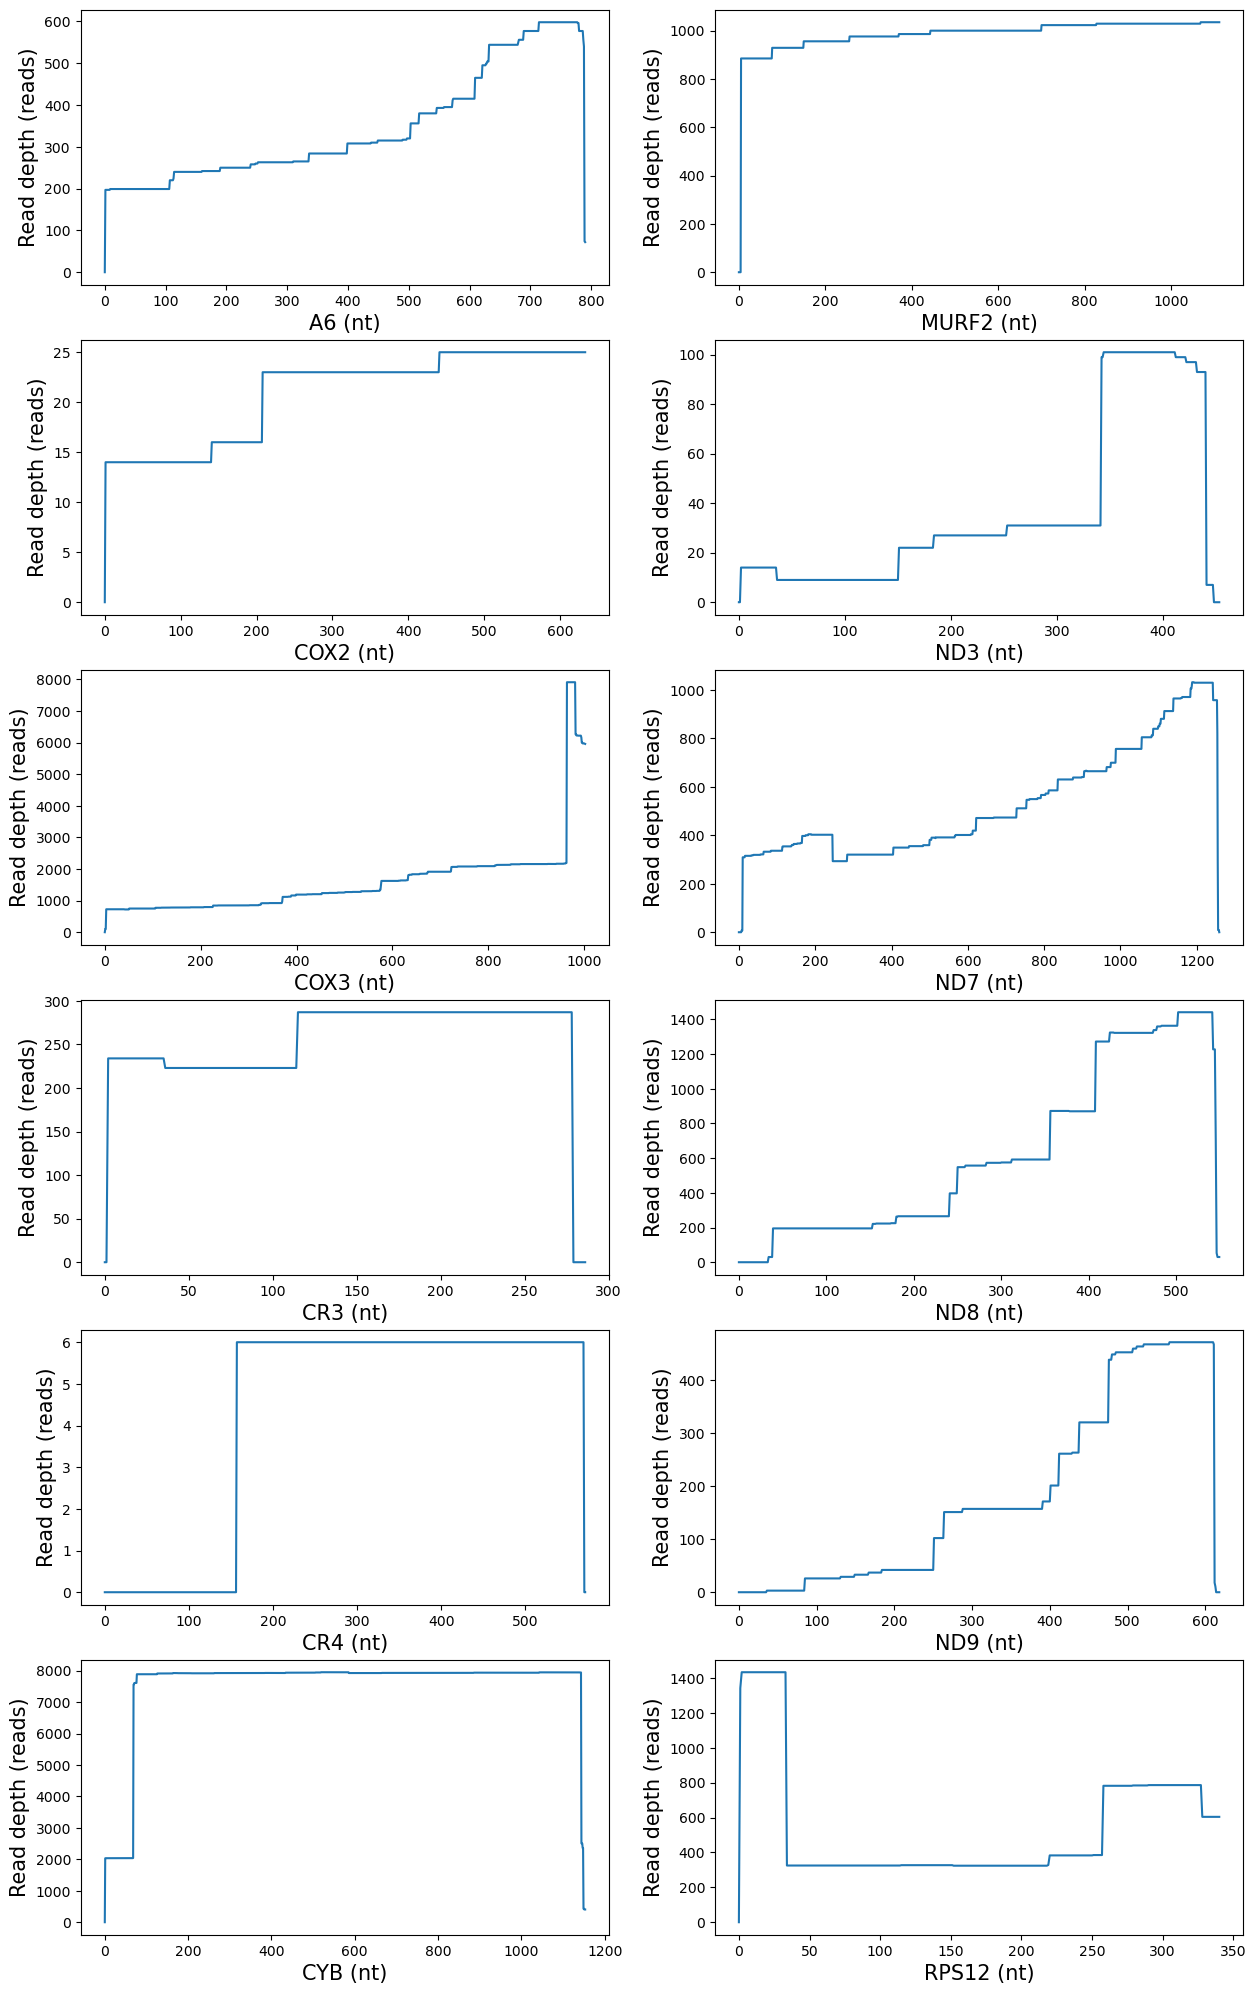

In [29]:
coverage=mRNA_coverage(blastedf,edmrna,unmrna,copy_dict,edited=True,figheight=25)

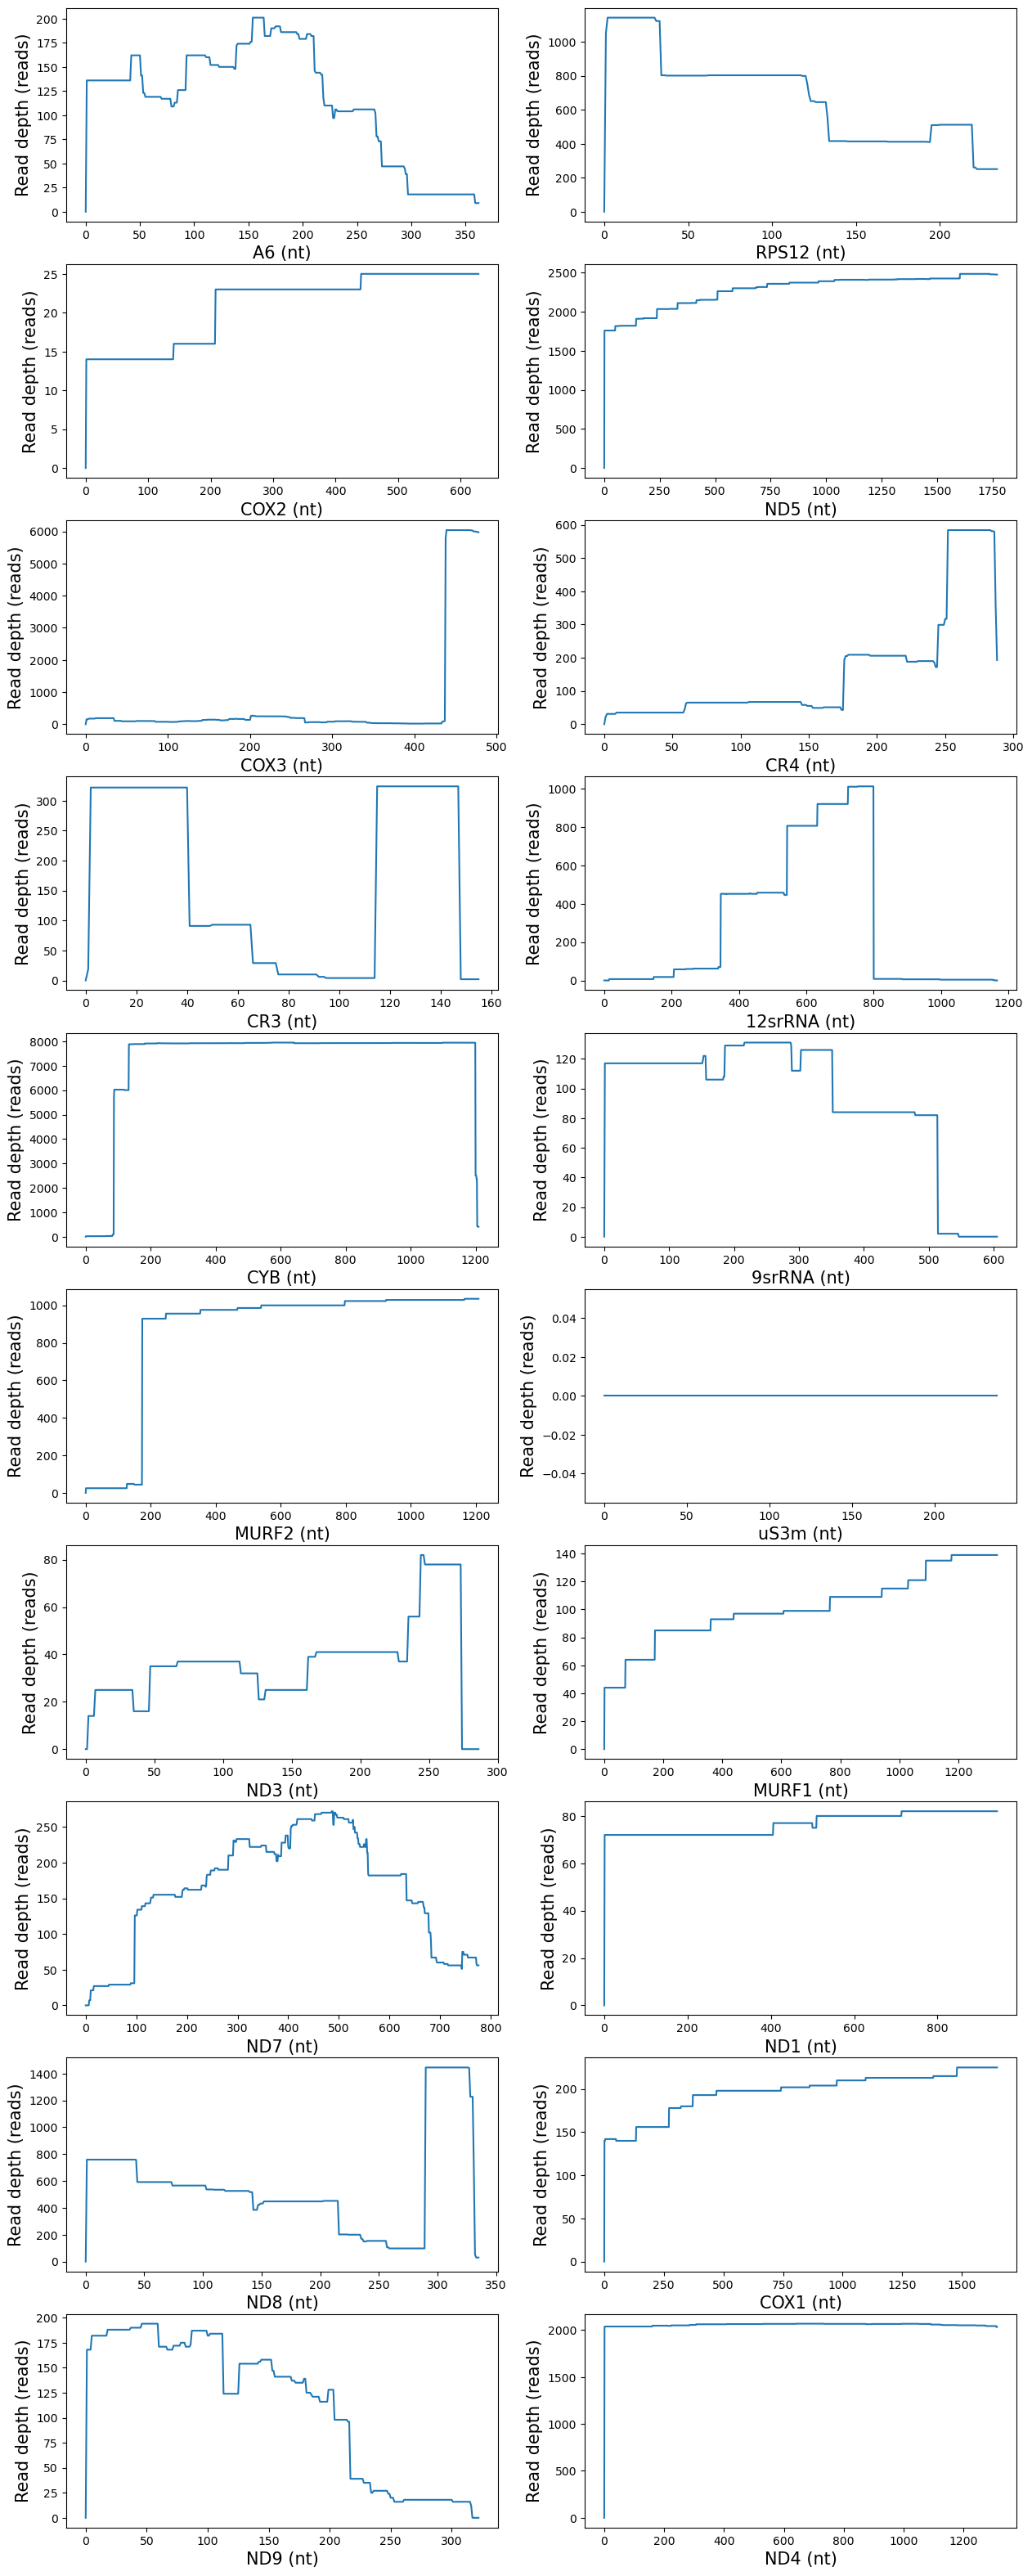

In [25]:
coverage=mRNA_coverage(blastunf,edmrna,unmrna,copy_dict,edited=False,figheight=40)

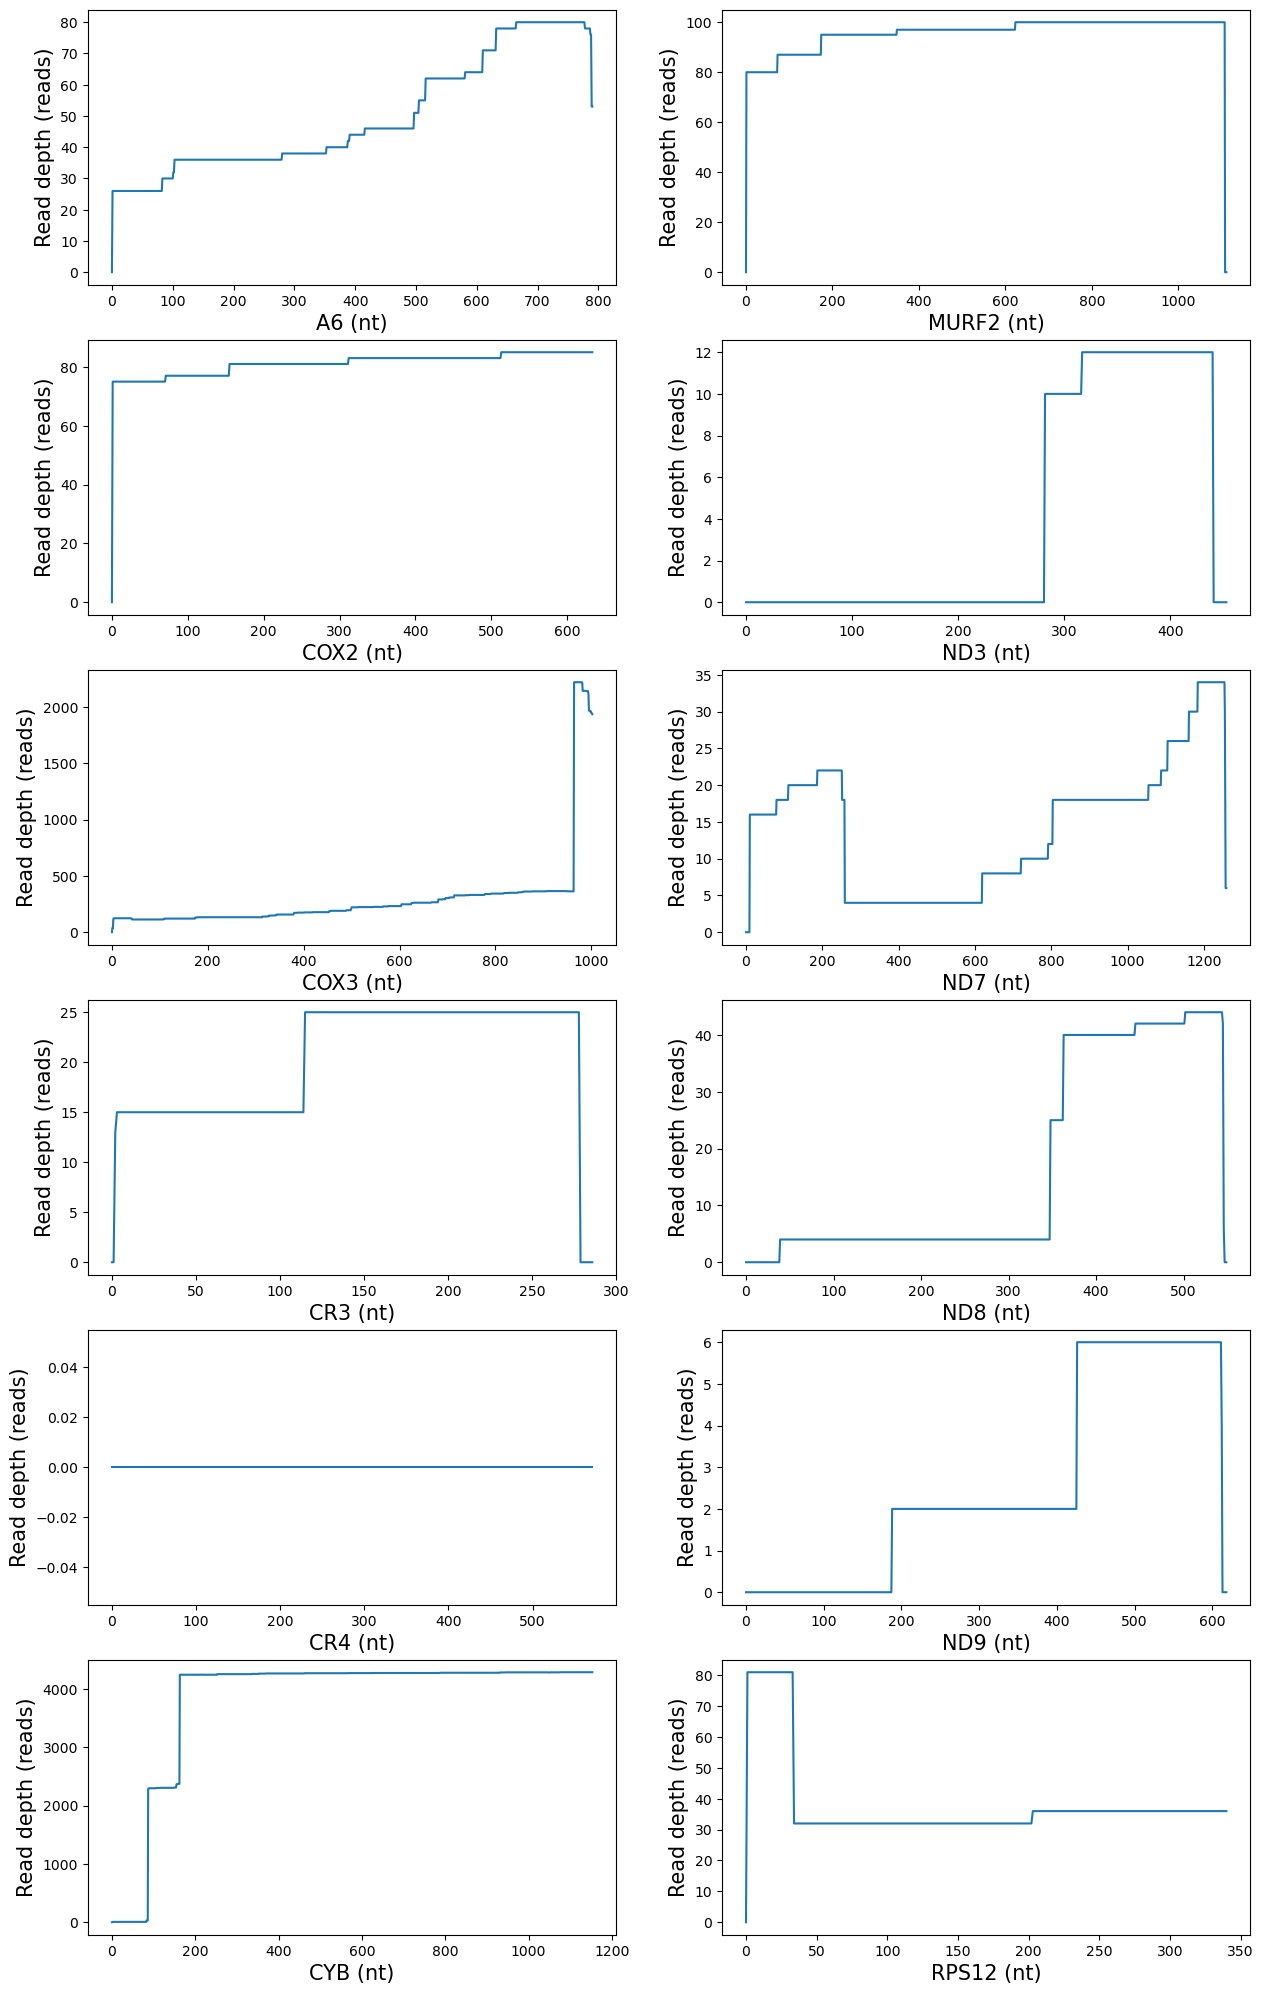

In [28]:
coverage=mRNA_coverage(blasted_epi,edmrna,unmrna,epi_copy,edited=True,figheight=25)

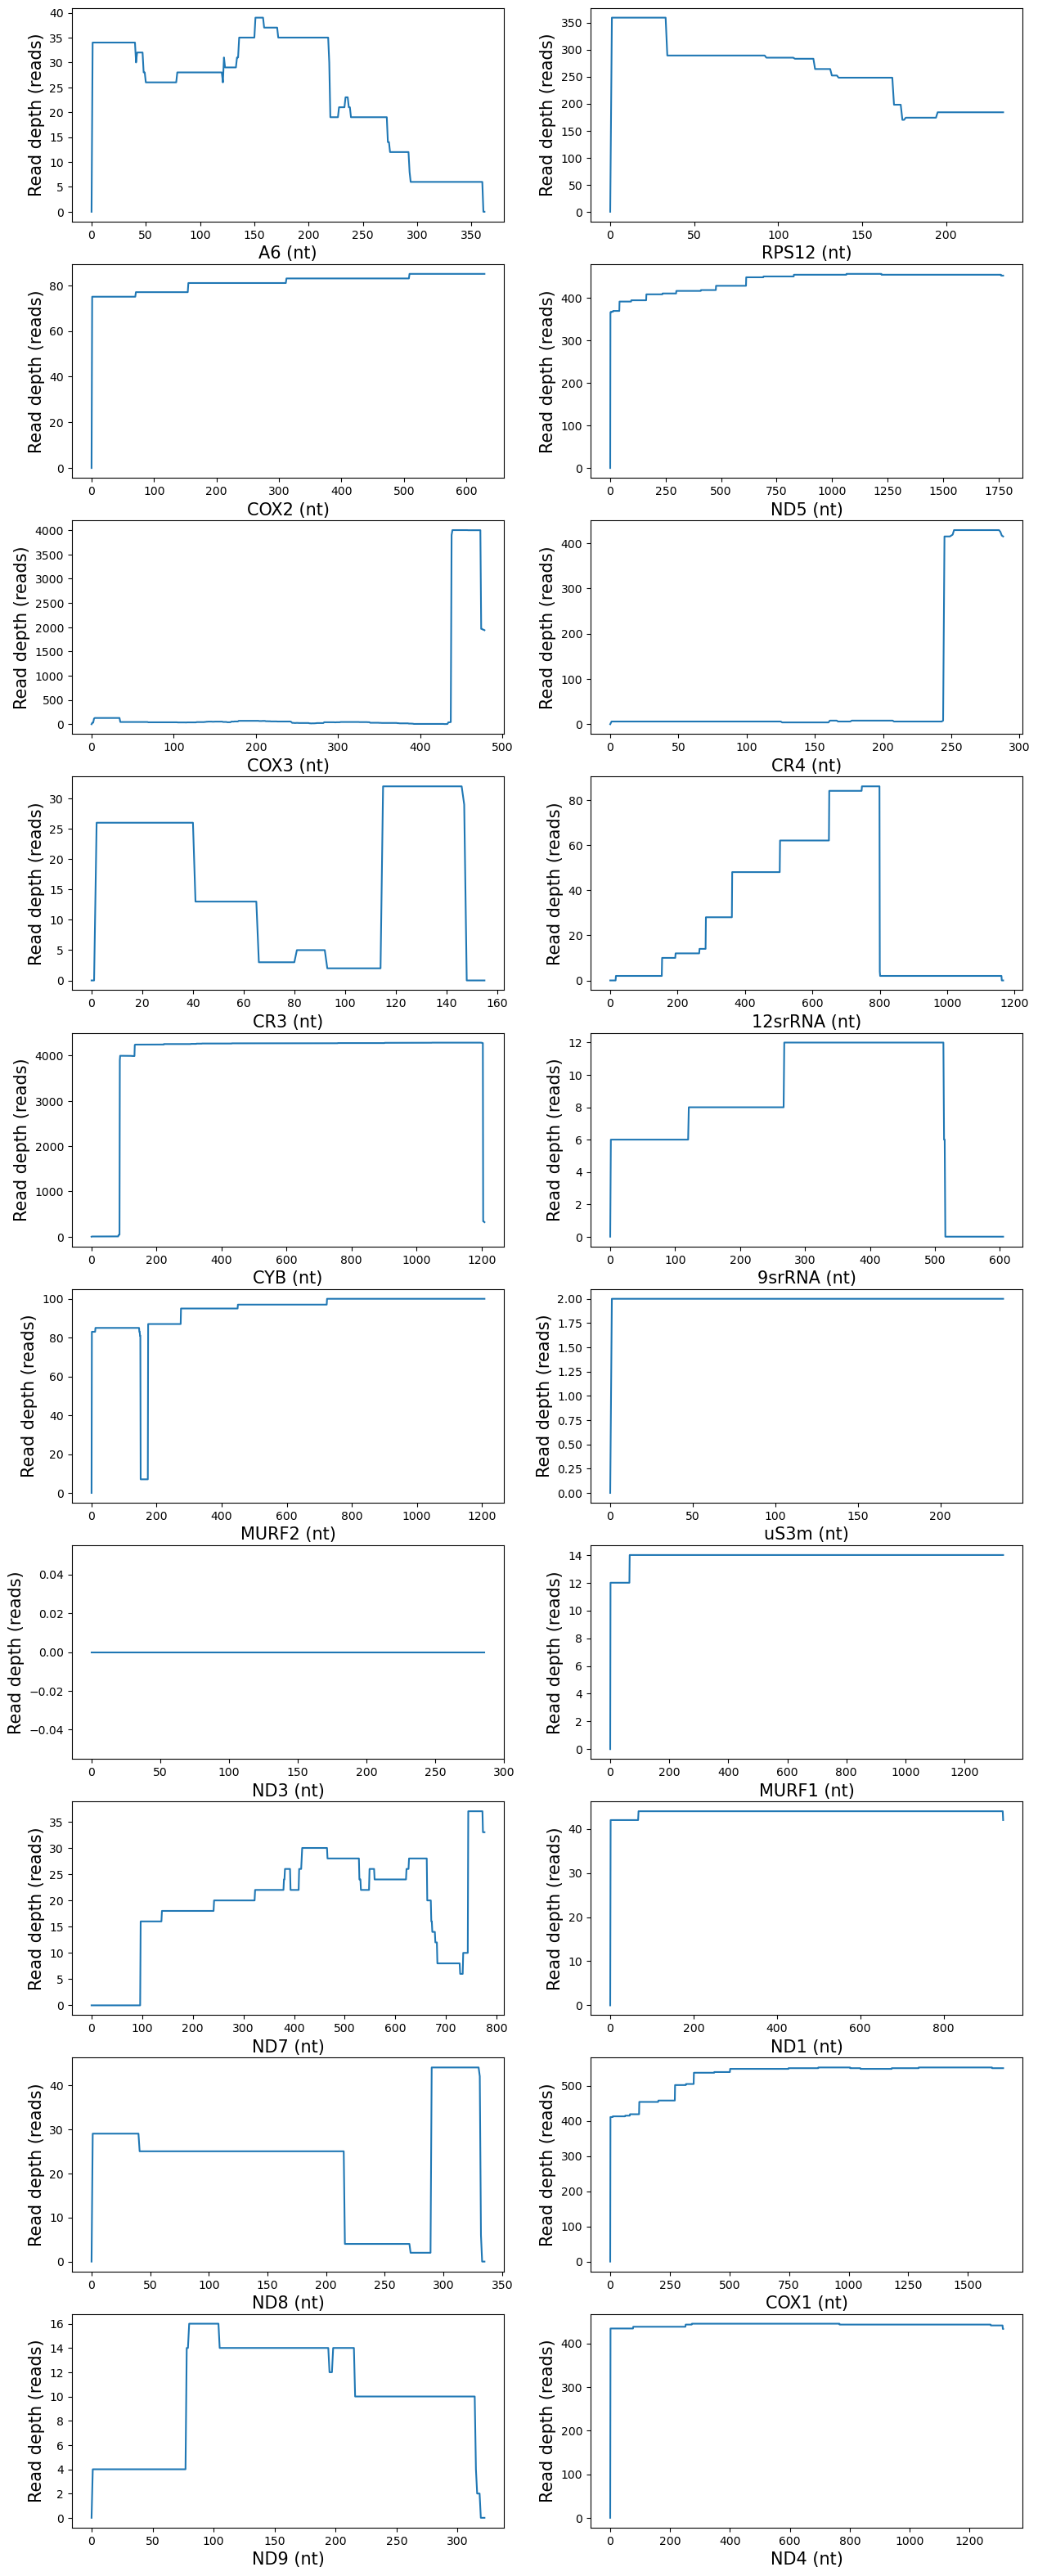

In [27]:
coverage=mRNA_coverage(blastun_epi,edmrna,unmrna,epi_copy,edited=False,figheight=40)

In [26]:
def plot_percentage_edited_reads(combined,copy_dict,pacbio,colors,mrnas):
    edited_len={mrna:{'edited':0,'unedited':0} for mrna in mrnas}
    for mrna in mrnas:
        for k,read in combined.items():
            for hit in read:
                anno=hit['query'].replace('_un','').replace('_ed','')
                cpnb=copy_dict[k]
                if mrna in anno:
                    length=hit['send']-hit['sstart']
                    if 'ed' in hit['query']:
                        #edited_len[mrna]['edited']+=length*cpnb
                        edited_len[mrna]['edited']+=cpnb
                    else:
                        #edited_len[mrna]['unedited']+=length*cpnb
                        edited_len[mrna]['unedited']+=cpnb
    #normalize to total transcript number
    total=sum(copy_dict.values())
    edited_len={mrna:{k:v/total for k,v in edited_len[mrna].items()} for mrna in mrnas}
    return(edited_len)
#summary of relative editing sequence length
def plot_gRNA_stats_multi_strain (edit_len1,edit_len2,width=0.35,figw=20,figh=15,title='Coverage of Editing Sites on mRNA'):
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))
    x,adj,strains= np.arange(0,len(edit_len1),1)*(width*1.2*(2+1)),0,['BSF','Epimastigote']
    for len_dct,strain in zip([edit_len1,edit_len2],strains):
        df=pd.DataFrame.from_dict(len_dct,orient='index')
        axs.bar(x+adj, (df['edited']), width, label='edited',color='cornflowerblue')
        axs.bar(x+adj, (df['unedited']), width, 
                bottom=(df['edited']),label='not edited',
                color='lightcoral')
        #annotate number of gNRAs
       # for loc,name in zip(x+adj,df.index):
       #     axs.text(loc-width/2,df['insertions'][name]+df['deletions'][name]+1,df['total gRNAs'][name],fontsize=20)
        #annotate strains
        #for loc in x+adj:
        #axs.text((x+adj)[0]-width/2,(df['insertions'][name]+df['deletions'][name])/2,strain,fontsize=20,rotation='vertical',color='white')
        adj+=width*1.2
    #styling
    axs.set_xticks(x)
    axs.set_xticklabels(list(df.index)) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 15)
    axs.tick_params(axis='y', labelsize= 15)
    axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('normalized read counts',fontsize=20)
    axs.set_title(title,fontsize=20) 
    axs.set_facecolor("white")
    #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    #plt.grid(True)
    plt.show()

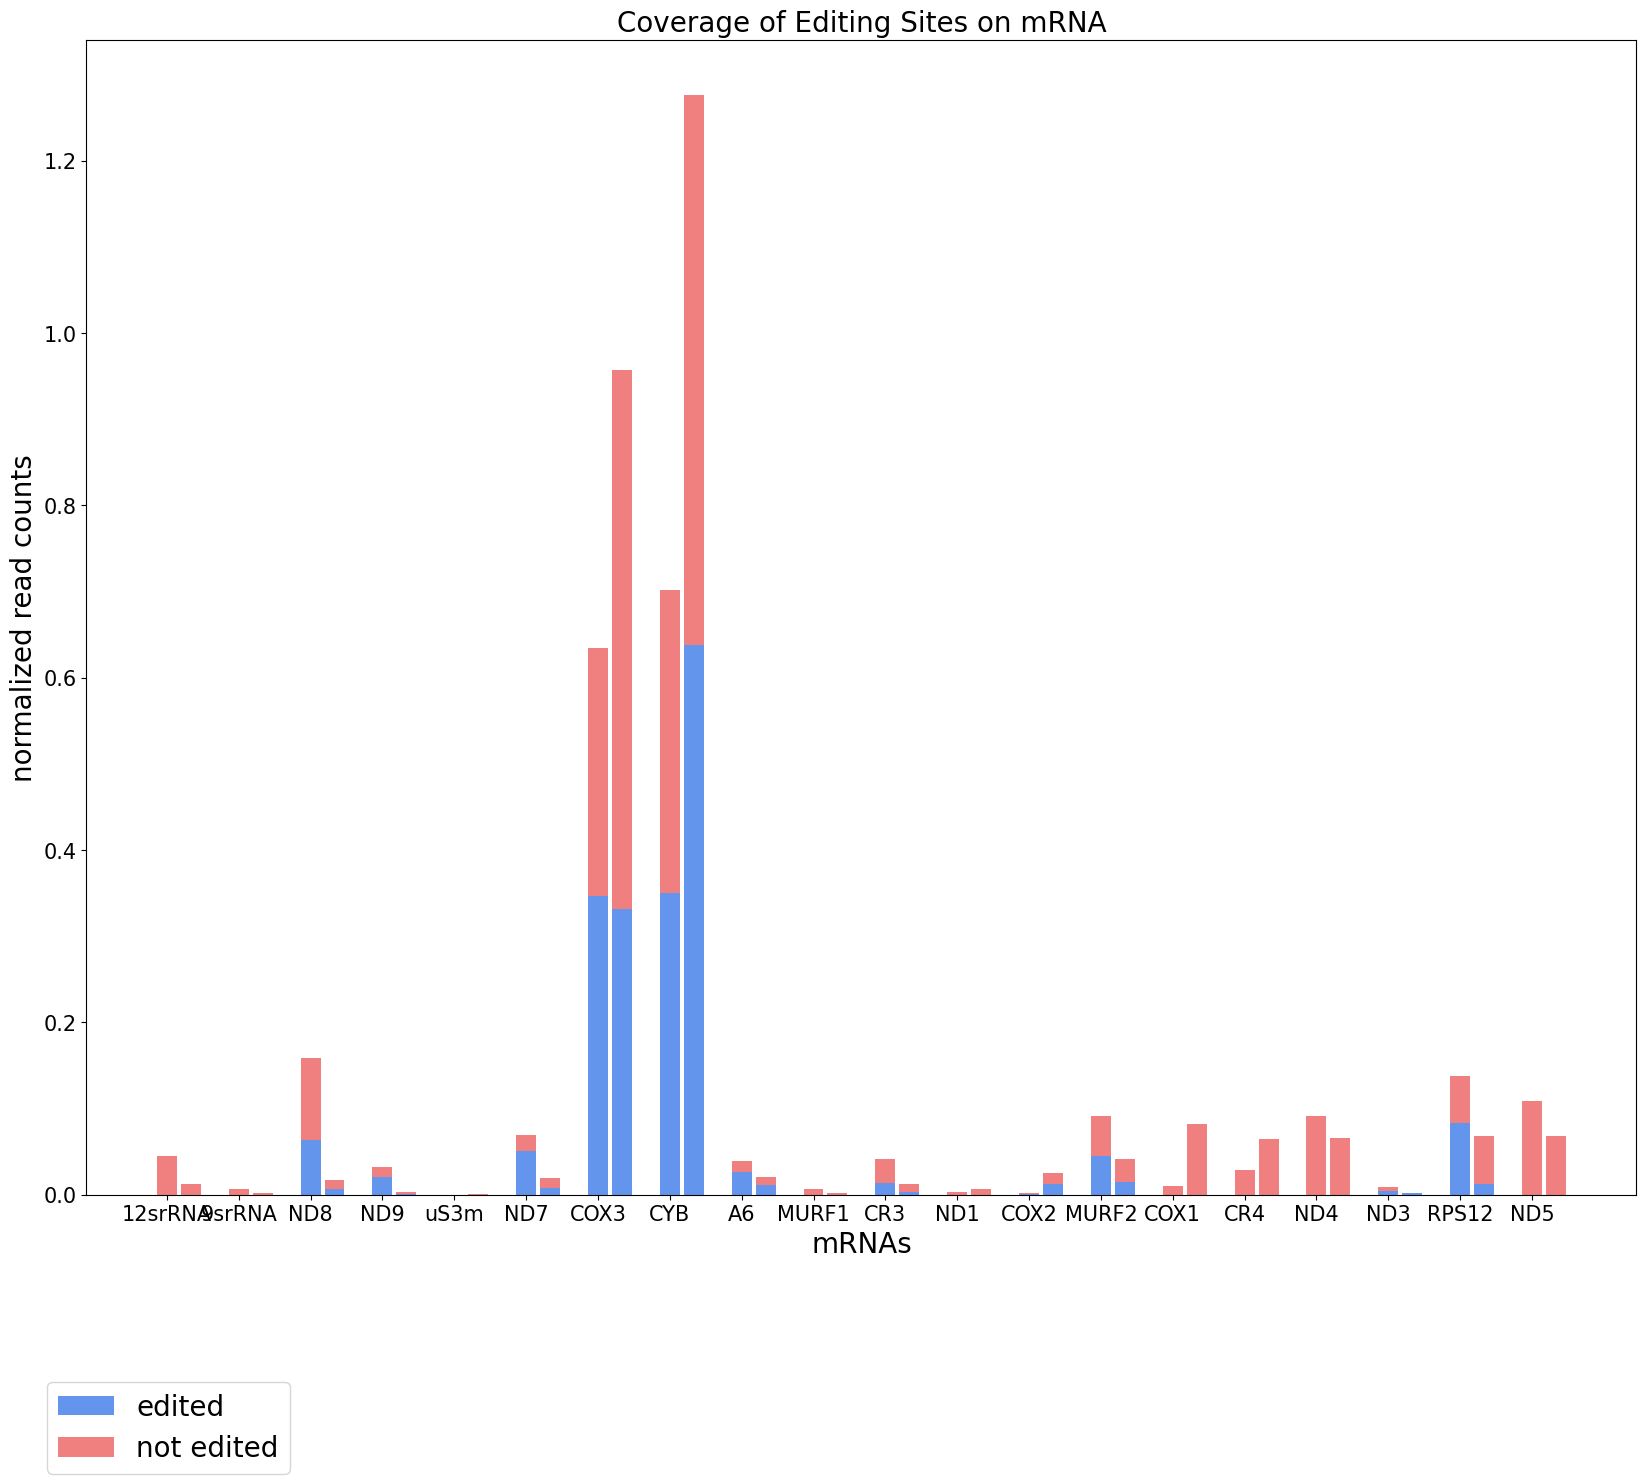

In [27]:
edited_len=plot_percentage_edited_reads(combined,copy_dict,pacbio,colors,mrnas)
epi_edited_len=plot_percentage_edited_reads(combined_epi,epi_copy,epipacbio,colors,mrnas)
plot_gRNA_stats_multi_strain (edited_len,epi_edited_len,width=0.35,figw=20,figh=15,title='Coverage of Editing Sites on mRNA')

In [28]:
pd.DataFrame.from_dict(edited_len,orient='index')

,edited,unedited
12srRNA,0.000000,0.045136
9srRNA,0.000000,0.007062
ND8,0.063383,0.095491
ND9,0.020660,0.011975
uS3m,0.000000,0.000000
ND7,0.050268,0.019344
COX3,0.347180,0.286955
CYB,0.350294,0.351390
A6,0.026230,0.012984
MURF1,0.000000,0.006097


In [29]:
annotate=[len(set([d['query'].replace('ed','').replace('un','') for d in v])) for k,v in combined.items()]


In [30]:
#plot basic analysis
def mrna_percent(combined,mrnas,colors,copy_dict):
    #consider unique transcripts only
    #annotate=[set([d['query'] for d in v]) for k,v in combined.items()]
    #percent={mrna:sum([1 for read in annotate for hit in read if mrna in hit]) for mrna in mrnas}
    #use real number of reads: # full length coverage
    annotate={k:set([d['query'] for d in v]) for k,v in combined.items()}
    percent={mrna:sum([copy_dict[read] for read,anno in annotate.items() if mrna in [i.split('_')[0] for i in anno]]) for mrna in mrnas}
    #for k,v in percent.items():
    #    print(f"{k}:{v}")
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10), sharey=False)
    axs[0].pie(percent.values(),labels=percent.keys(),colors=[colors.get(m,'gray') for m in mrnas])
    #check how many mRNAs are present on the hit
    annotate={1:[],2:[],3:[]}
    for k,v in combined.items():
        syn=len(set([d['query'].replace('ed','').replace('un','') for d in v]))
        if syn in annotate:
            annotate[syn].append(copy_dict[k])
        else:
            annotate[syn]=[copy_dict[k]]
    #consider unique transcripts only
    #annotate=[len(set([d['query'].replace('ed','').replace('un','') for d in v])) for k,v in combined.items()]
    axs[1].bar(annotate.keys(),[sum(v) for k,v in annotate.items()])
    splice={k:sum(v) for k,v in annotate.items()}
    print({k:round(v/sum(splice.values())*100,2) for k,v in splice.items()})
    plt.show()
    return(percent)
def z_test(perc1,perc2,p=0.05):
    #get expected ratio for perc1
    ratio={k:v/sum(perc1.values()) for k,v in perc1.items()}
    #print(ratio)
    #perc2={k:v/sum(perc2.values())*scale for k,v in perc2.items()}
    fexp=[sum(perc2.values())*ratio[k] for k in perc2]
    fobs=[perc2[k] for k in perc2]
    chi=chisquare(fobs, f_exp=fexp)
    print(chi.pvalue)
    for k in perc2:
        fobs=[perc2[k],sum(perc2.values())-perc2[k]]
        fexp=[sum(perc2.values())*ratio[k],sum(perc2.values())*(1-ratio[k])]
        def test_chi():
            chi=chisquare(fobs, f_exp=fexp)
            if chi.pvalue<p:
                print(k,fobs,fexp,chi.pvalue)
            else:
                print(f"no significant difference: {k}")
        def test_z():
            z=binomtest(perc2[k],sum(perc2.values()),ratio[k])
            if z.pvalue<p:
                print(k,perc2[k],sum(perc2.values())*ratio[k],z.pvalue)
            else:
                print(f"no significant difference: {k}")
        test_z()
def compare_proportion(bsf_perc,epi_perc,colors,width=0.35,):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=False)
    data=[pd.DataFrame.from_dict({k:v/sum(bsf_perc.values())*100 for k,v in bsf_perc.items()},orient='index'),
          pd.DataFrame.from_dict({k:v/sum(epi_perc.values())*100 for k,v in epi_perc.items()},orient='index')]
    labels=['BSF ratio','EMF ratio']
    x,adj= np.arange(0,len(data),1)*(width*1.2),0
    for df in data:
        bttm=0
        for mrna in mrnas:
            axs.bar(adj, df.loc[mrna], width,bottom=bttm,label=mrna,color=colors.get(mrna,'grey'))
            bttm+=df.loc[mrna]
        adj+=width*1.2
    #styling
    axs.set_xticks(x)
    axs.set_xticklabels(labels,rotation= 90) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 20)
    axs.tick_params(axis='y', labelsize= 15)
    #axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('Proportion of reads(%)',fontsize=20)
    axs.set_facecolor("white")
    #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.1, -0.2))
    plt.grid(True)
    plt.show()

{1: 66.36, 2: 33.6, 3: 0.04}


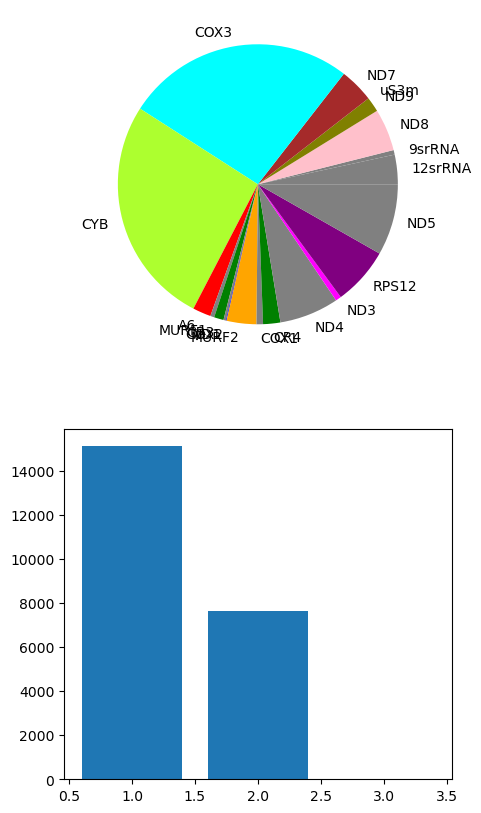

{1: 28.83, 2: 70.9, 3: 0.27}


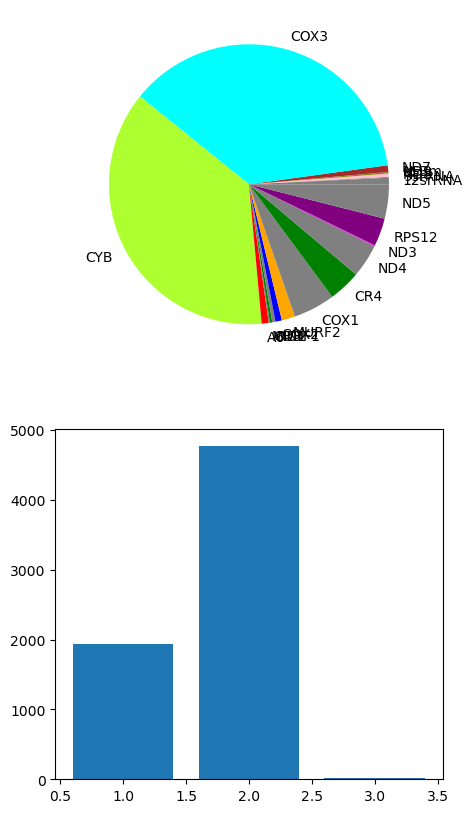

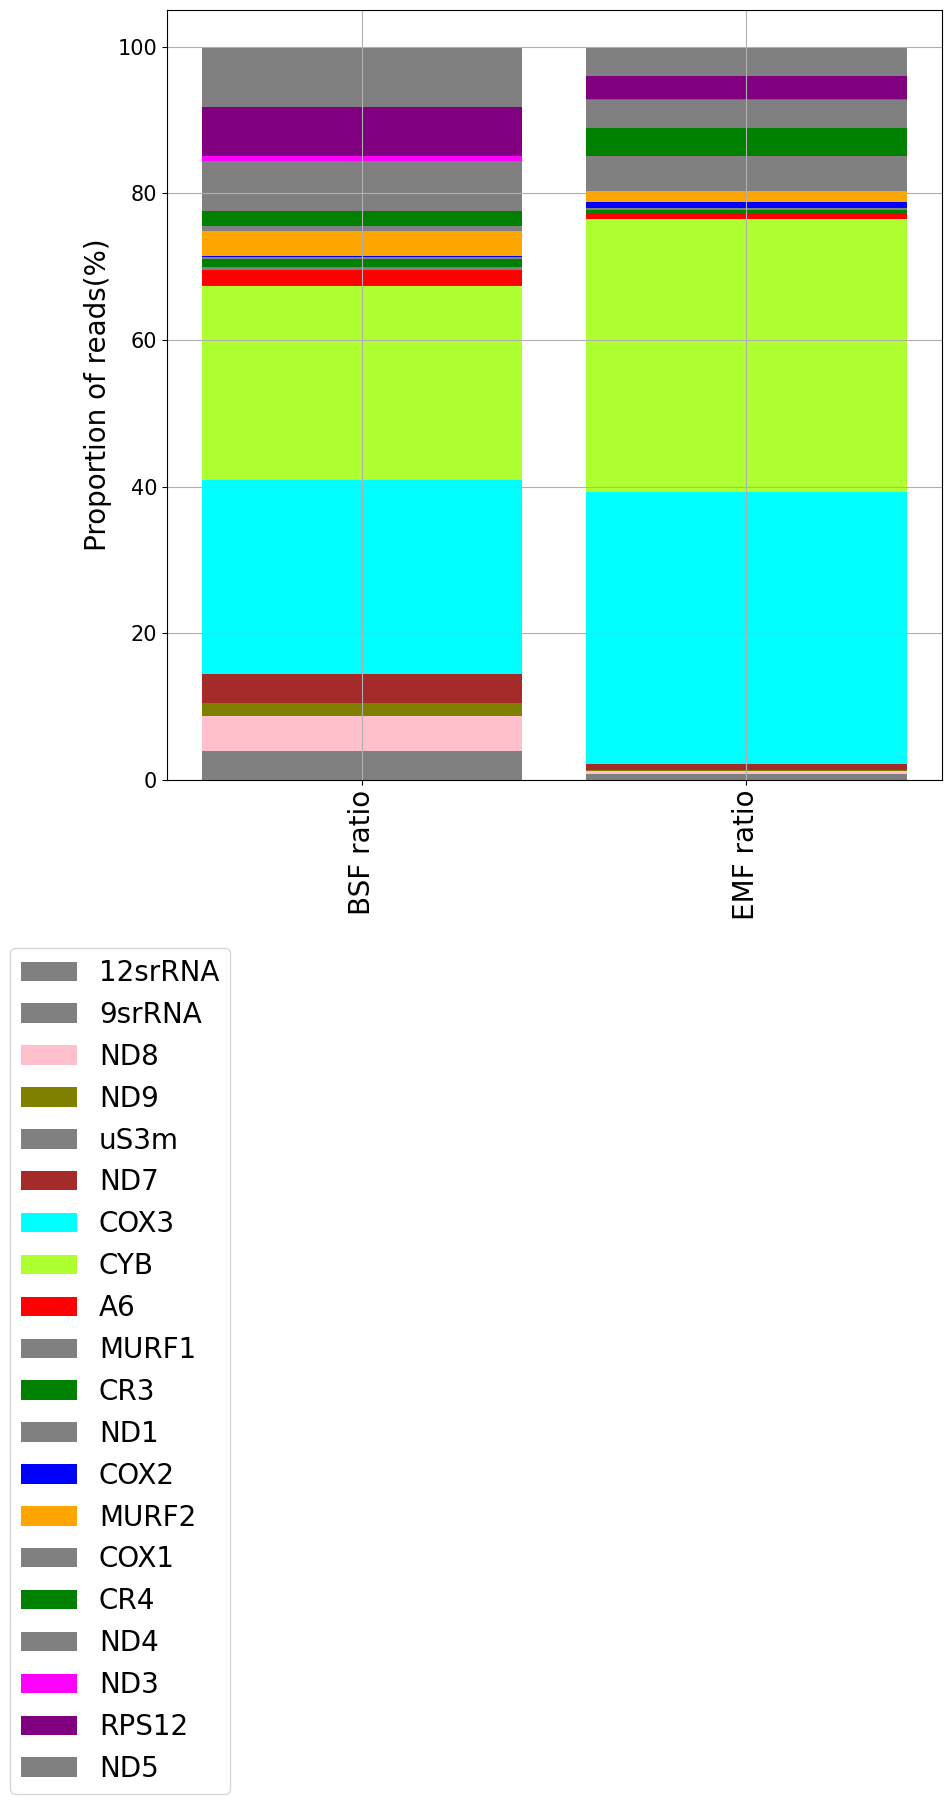

In [31]:
bsf_perc=mrna_percent(combined,mrnas,colors,copy_dict)
epi_perc=mrna_percent(combined_epi,mrnas,colors,epi_copy)
compare_proportion(bsf_perc,epi_perc,colors,width=0.35,)

In [32]:
print(bsf_perc,'\n', epi_perc)
# number of A6 transcripts with the alternative editing pattern BSF
print(sum([2,2,2,2,8,2,24,3,2,24,6,21]))
#number of A6 transcripts with the alternative editing pattern EPF
print(sum([26,4,2,2,2,2,2,4,7,7,2]),sum([26,4,2,2,2,2,2,4,7,7,2])/epi_perc['A6'])


{'12srRNA': 1029, '9srRNA': 161, 'ND8': 1471, 'ND9': 520, 'uS3m': 0, 'ND7': 1198, 'COX3': 8003, 'CYB': 8011, 'A6': 636, 'MURF1': 139, 'CR3': 333, 'ND1': 84, 'COX2': 25, 'MURF2': 1039, 'COX1': 227, 'CR4': 601, 'ND4': 2074, 'ND3': 198, 'RPS12': 2021, 'ND5': 2491} 
 {'12srRNA': 86, '9srRNA': 12, 'ND8': 44, 'ND9': 18, 'uS3m': 2, 'ND7': 89, 'COX3': 4274, 'CYB': 4298, 'A6': 94, 'MURF1': 14, 'CR3': 32, 'ND1': 44, 'COX2': 85, 'MURF2': 178, 'COX1': 556, 'CR4': 429, 'ND4': 445, 'ND3': 12, 'RPS12': 373, 'ND5': 456}
98
60 0.6382978723404256


In [33]:
z_test(bsf_perc,epi_perc,p=0.05)

0.0
12srRNA 86 392.44205412907706 6.109701104729674e-80
9srRNA 12 61.40249826509368 2.915170200053756e-14
ND8 44 561.0128878754832 9.124441283275222e-183
ND9 18 198.31862793694853 1.5679938738605697e-61
uS3m 2 0.0 0.0
ND7 89 456.8956082085853 6.946970111046753e-101
COX3 4274 3052.199960344999 9.681464420329624e-137
CYB 4298 3055.251016159413 4.1119824466723116e-141
A6 94 242.55893724596012 8.86916221757738e-28
MURF1 14 53.012094775453555 3.671632400933655e-10
CR3 32 127.00019827500745 1.0924952862640122e-23
ND1 44 32.03608605135322 0.04115046133669339
COX2 85 9.534549420045604 3.9322420872247546e-50
MURF2 178 396.2558738970952 1.433214580173777e-35
COX1 556 86.57370873401408 7.372876013383888e-252
CR4 429 229.2105680578963 8.702377945696382e-33
ND4 445 790.9862198869832 2.609230734560715e-43
ND3 12 75.51363140676118 2.4233707055006786e-19
RPS12 373 770.7729751164866 3.976621398721327e-60
ND5 456 950.022504213344 6.059561120335521e-76


/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


In [34]:
print({k:v/sum(bsf_perc.values()) for k,v in bsf_perc.items()})
print({k:v/sum(epi_perc.values()) for k,v in epi_perc.items()})
0.370331860324062+0.3724114028247119

{'12srRNA': 0.034004163775156145, '9srRNA': 0.005320379366180893, 'ND8': 0.04861042265622418, 'ND9': 0.017183833977727107, 'uS3m': 0.0, 'ND7': 0.039588909817917455, 'COX3': 0.2644658140841347, 'CYB': 0.26473018076071514, 'A6': 0.021017150788143153, 'MURF1': 0.004593371005584746, 'CR3': 0.01100426291265986, 'ND1': 0.002775850104094379, 'COX2': 0.0008261458643138033, 'MURF2': 0.03433462212088166, 'COX1': 0.007501404447969333, 'CR4': 0.01986054657810383, 'ND4': 0.06853706090347311, 'ND3': 0.006543075245365322, 'RPS12': 0.06678563167112786, 'ND5': 0.08231717392022736}
{'12srRNA': 0.007451693960661988, '9srRNA': 0.0010397712503249284, 'ND8': 0.0038124945845247377, 'ND9': 0.0015596568754873928, 'uS3m': 0.00017329520838748808, 'ND7': 0.0077116367732432195, 'COX3': 0.370331860324062, 'CYB': 0.3724114028247119, 'A6': 0.008144874794211941, 'MURF1': 0.0012130664587124166, 'CR3': 0.0027727233341998093, 'ND1': 0.0038124945845247377, 'COX2': 0.007365046356468244, 'MURF2': 0.015423273546486439, 'COX1

0.7427432631487739

In [35]:
z_test(bsf_perc,epi_perc,p=0.05)

0.0
12srRNA 86 392.44205412907706 6.109701104729674e-80
9srRNA 12 61.40249826509368 2.915170200053756e-14
ND8 44 561.0128878754832 9.124441283275222e-183
ND9 18 198.31862793694853 1.5679938738605697e-61
uS3m 2 0.0 0.0
ND7 89 456.8956082085853 6.946970111046753e-101
COX3 4274 3052.199960344999 9.681464420329624e-137
CYB 4298 3055.251016159413 4.1119824466723116e-141
A6 94 242.55893724596012 8.86916221757738e-28
MURF1 14 53.012094775453555 3.671632400933655e-10
CR3 32 127.00019827500745 1.0924952862640122e-23
ND1 44 32.03608605135322 0.04115046133669339
COX2 85 9.534549420045604 3.9322420872247546e-50
MURF2 178 396.2558738970952 1.433214580173777e-35
COX1 556 86.57370873401408 7.372876013383888e-252
CR4 429 229.2105680578963 8.702377945696382e-33
ND4 445 790.9862198869832 2.609230734560715e-43
ND3 12 75.51363140676118 2.4233707055006786e-19
RPS12 373 770.7729751164866 3.976621398721327e-60
ND5 456 950.022504213344 6.059561120335521e-76


In [36]:
#plot basic analysis
def mrna_percent_no_CYV_COX3(combined,mrnas,colors,copy_dict):
    #use real number of reads: # full length coverage
    annotate={k:set([d['query'] for d in v]) for k,v in combined.items()}
    percent={mrna:sum([copy_dict[read] for read,anno in annotate.items() if mrna in [i.split('_')[0] for i in anno]]) 
             for mrna in mrnas if mrna not in ['CYB','COX3']}
    for k,v in percent.items():
        print(f"{k}:{v}")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 10), sharey=False)
    ax.pie(percent.values(),labels=percent.keys(),colors=[colors.get(m,'gray') for m in mrnas])
    return(percent)

12srRNA:1029
9srRNA:161
ND8:1471
ND9:520
uS3m:0
ND7:1198
A6:636
MURF1:139
CR3:333
ND1:84
COX2:25
MURF2:1039
COX1:227
CR4:601
ND4:2074
ND3:198
RPS12:2021
ND5:2491
12srRNA:86
9srRNA:12
ND8:44
ND9:18
uS3m:2
ND7:89
A6:94
MURF1:14
CR3:32
ND1:44
COX2:85
MURF2:178
COX1:556
CR4:429
ND4:445
ND3:12
RPS12:373
ND5:456
0.0
12srRNA 86 214.43819751526635 1.5235665359964898e-24
9srRNA 12 33.55155471327297 3.7723964277335705e-05
ND8 44 306.5486769144381 4.8092250579765045e-84
ND9 18 108.36526988137854 2.8795626970056435e-27
uS3m 2 0.0 0.0
ND7 89 249.65691022671442 1.5764686531725745e-33
A6 94 132.5390608549168 0.0003728364545346136
MURF1 14 28.96687021829157 0.003566209757353112
CR3 32 69.39545167403664 7.374627109976477e-07
ND1 44 17.505158980838072 9.159597289062625e-08
COX2 85 5.209868744297045 6.023332826777016e-71
MURF2 178 216.5221450129852 0.005880541880550786
COX1 556 47.305608198217165 0.0
CR4 429 125.24524461290098 4.709665765226979e-107
no significant difference: ND4
ND3 12 41.26216045483259

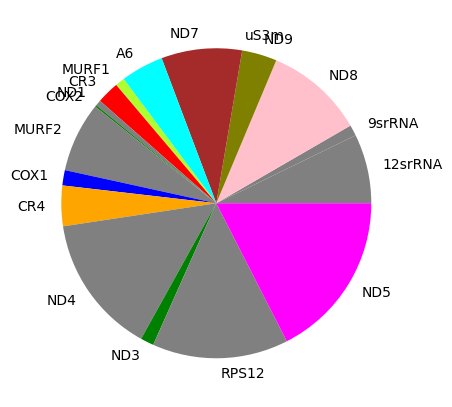

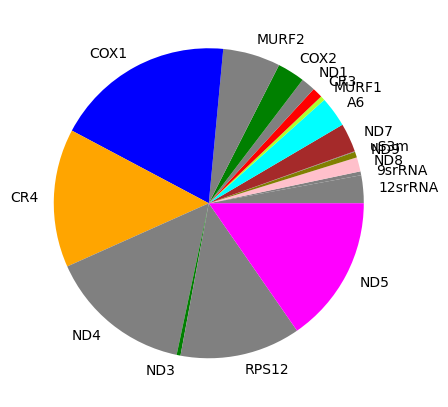

In [37]:
bsp_perc2=mrna_percent_no_CYV_COX3(combined,mrnas,colors,copy_dict)
epi_perc2=mrna_percent_no_CYV_COX3(combined_epi,mrnas,colors,epi_copy)
z_test(bsp_perc2,epi_perc2,p=0.05)

In [38]:
#only interesctions are minimally edited genes
intersections=set(blastedf.keys()).intersection(set(blastunf.keys()))
mrna=set([blastunf[k]['query'] for k in intersections])
blastunf['transcript/77912_27.0_389.0']

{'query': 'A6_un',
 'subject': 'transcript/77912',
 'identity': 100.0,
 'alignment_length': 363.0,
 'mismatches': 0.0,
 'gap': 0.0,
 'qstart': 1.0,
 'qend': 363.0,
 'sstart': 27.0,
 'send': 389.0,
 'evalue': 2.19e-117,
 'bit_score': 422.0}